In [1]:
import gymnasium as gym
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from cellitaire.environment.cellitaire_env import CellitaireEnv

In [2]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        self.actions.append(action)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

In [3]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [4]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [5]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               

In [6]:
env = CellitaireEnv(None)

In [ ]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, input_dims=(7 * 12 + 6,), batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)

n_games = 15000

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation, reward, done, info = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)

... saving models ...
episode 0 score -255.0 avg score -255.0 time_steps 271 learning_steps 13
episode 1 score -296.0 avg score -275.5 time_steps 577 learning_steps 28
episode 2 score -296.0 avg score -282.3 time_steps 883 learning_steps 44
episode 3 score -285.0 avg score -283.0 time_steps 1200 learning_steps 60
episode 4 score -287.0 avg score -283.8 time_steps 1515 learning_steps 75
episode 5 score -291.0 avg score -285.0 time_steps 1826 learning_steps 91
episode 6 score -292.0 avg score -286.0 time_steps 2136 learning_steps 106
episode 7 score -283.0 avg score -285.6 time_steps 2455 learning_steps 122
episode 8 score -253.0 avg score -282.0 time_steps 2728 learning_steps 136
episode 9 score -286.0 avg score -282.4 time_steps 3044 learning_steps 152
episode 10 score -286.0 avg score -282.7 time_steps 3360 learning_steps 168
episode 11 score -286.0 avg score -283.0 time_steps 3676 learning_steps 183
episode 12 score -286.0 avg score -283.2 time_steps 3992 learning_steps 199
episode 1

episode 96 score -294.0 avg score -158.4 time_steps 17518 learning_steps 875
episode 97 score -50.0 avg score -157.3 time_steps 17586 learning_steps 879
episode 98 score -120.0 avg score -156.9 time_steps 17724 learning_steps 886
episode 99 score -29.0 avg score -155.7 time_steps 17769 learning_steps 888
... saving models ...
episode 100 score -17.0 avg score -153.3 time_steps 17802 learning_steps 890
... saving models ...
episode 101 score -43.0 avg score -150.7 time_steps 17857 learning_steps 892
... saving models ...
episode 102 score -64.0 avg score -148.4 time_steps 17937 learning_steps 896
... saving models ...
episode 103 score -18.0 avg score -145.8 time_steps 17967 learning_steps 898
... saving models ...
episode 104 score -23.0 avg score -143.1 time_steps 18002 learning_steps 900
... saving models ...
episode 105 score -25.0 avg score -140.4 time_steps 18039 learning_steps 901
... saving models ...
episode 106 score -28.0 avg score -137.8 time_steps 18083 learning_steps 904
.

episode 184 score -189.0 avg score -32.2 time_steps 20447 learning_steps 1022
episode 185 score -2.0 avg score -32.1 time_steps 20461 learning_steps 1023
... saving models ...
episode 186 score -32.0 avg score -29.5 time_steps 20505 learning_steps 1025
... saving models ...
episode 187 score 2.0 avg score -29.1 time_steps 20515 learning_steps 1025
... saving models ...
episode 188 score -16.0 avg score -29.0 time_steps 20543 learning_steps 1027
... saving models ...
episode 189 score 1.0 avg score -28.9 time_steps 20554 learning_steps 1027
episode 190 score -159.0 avg score -30.1 time_steps 20737 learning_steps 1036
episode 191 score -46.0 avg score -30.4 time_steps 20799 learning_steps 1039
episode 192 score 3.0 avg score -30.1 time_steps 20808 learning_steps 1040
... saving models ...
episode 193 score 4.0 avg score -28.1 time_steps 20816 learning_steps 1040
... saving models ...
episode 194 score 3.0 avg score -25.4 time_steps 20825 learning_steps 1041
... saving models ...
episode 

episode 285 score -2.0 avg score -10.0 time_steps 22690 learning_steps 1134
episode 286 score -4.0 avg score -9.8 time_steps 22706 learning_steps 1135
episode 287 score 5.0 avg score -9.7 time_steps 22713 learning_steps 1135
episode 288 score 6.0 avg score -9.5 time_steps 22719 learning_steps 1135
episode 289 score 3.0 avg score -9.5 time_steps 22728 learning_steps 1136
... saving models ...
episode 290 score 6.0 avg score -7.8 time_steps 22734 learning_steps 1136
... saving models ...
episode 291 score 0.0 avg score -7.4 time_steps 22746 learning_steps 1137
... saving models ...
episode 292 score 4.0 avg score -7.4 time_steps 22754 learning_steps 1137
episode 293 score 4.0 avg score -7.4 time_steps 22762 learning_steps 1138
... saving models ...
episode 294 score 6.0 avg score -7.3 time_steps 22768 learning_steps 1138
... saving models ...
episode 295 score 6.0 avg score -7.3 time_steps 22774 learning_steps 1138
... saving models ...
episode 296 score 6.0 avg score -7.2 time_steps 227

episode 388 score 6.0 avg score 2.1 time_steps 23708 learning_steps 1185
... saving models ...
episode 389 score 6.0 avg score 2.1 time_steps 23714 learning_steps 1185
episode 390 score 6.0 avg score 2.1 time_steps 23720 learning_steps 1186
... saving models ...
episode 391 score 4.0 avg score 2.2 time_steps 23728 learning_steps 1186
... saving models ...
episode 392 score 6.0 avg score 2.2 time_steps 23734 learning_steps 1186
... saving models ...
episode 393 score 6.0 avg score 2.2 time_steps 23740 learning_steps 1187
episode 394 score 2.0 avg score 2.2 time_steps 23750 learning_steps 1187
episode 395 score 3.0 avg score 2.1 time_steps 23759 learning_steps 1187
episode 396 score 3.0 avg score 2.1 time_steps 23768 learning_steps 1188
episode 397 score -5.0 avg score 2.0 time_steps 23785 learning_steps 1189
episode 398 score 6.0 avg score 2.0 time_steps 23791 learning_steps 1189
episode 399 score 5.0 avg score 2.0 time_steps 23798 learning_steps 1189
episode 400 score 6.0 avg score 2.0

episode 501 score 3.0 avg score 2.0 time_steps 24885 learning_steps 1244
episode 502 score 0.0 avg score 2.0 time_steps 24897 learning_steps 1244
episode 503 score 2.0 avg score 2.0 time_steps 24907 learning_steps 1245
episode 504 score 3.0 avg score 2.0 time_steps 24916 learning_steps 1245
episode 505 score 2.0 avg score 1.9 time_steps 24926 learning_steps 1246
episode 506 score 5.0 avg score 2.1 time_steps 24933 learning_steps 1246
episode 507 score 1.0 avg score 2.1 time_steps 24944 learning_steps 1247
episode 508 score 6.0 avg score 2.2 time_steps 24950 learning_steps 1247
episode 509 score 3.0 avg score 2.1 time_steps 24959 learning_steps 1247
episode 510 score 1.0 avg score 2.1 time_steps 24970 learning_steps 1248
episode 511 score 6.0 avg score 2.2 time_steps 24976 learning_steps 1248
episode 512 score 3.0 avg score 2.1 time_steps 24985 learning_steps 1249
episode 513 score 6.0 avg score 2.2 time_steps 24991 learning_steps 1249
episode 514 score 5.0 avg score 2.2 time_steps 2499

episode 606 score -8.0 avg score 4.1 time_steps 25724 learning_steps 1286
episode 607 score 4.0 avg score 4.1 time_steps 25732 learning_steps 1286
episode 608 score 5.0 avg score 4.1 time_steps 25739 learning_steps 1286
episode 609 score 6.0 avg score 4.1 time_steps 25745 learning_steps 1287
episode 610 score 5.0 avg score 4.2 time_steps 25752 learning_steps 1287
episode 611 score 4.0 avg score 4.2 time_steps 25760 learning_steps 1288
episode 612 score 4.0 avg score 4.2 time_steps 25768 learning_steps 1288
episode 613 score 5.0 avg score 4.2 time_steps 25775 learning_steps 1288
episode 614 score 6.0 avg score 4.2 time_steps 25781 learning_steps 1289
episode 615 score 5.0 avg score 4.2 time_steps 25788 learning_steps 1289
episode 616 score 6.0 avg score 4.2 time_steps 25794 learning_steps 1289
episode 617 score 6.0 avg score 4.2 time_steps 25800 learning_steps 1290
... saving models ...
episode 618 score 6.0 avg score 4.2 time_steps 25806 learning_steps 1290
... saving models ...
episod

episode 715 score -59.0 avg score -16.0 time_steps 28596 learning_steps 1429
episode 716 score 6.0 avg score -16.0 time_steps 28602 learning_steps 1430
episode 717 score -21.0 avg score -16.2 time_steps 28635 learning_steps 1431
episode 718 score 3.0 avg score -16.3 time_steps 28644 learning_steps 1432
episode 719 score 4.0 avg score -16.3 time_steps 28652 learning_steps 1432
episode 720 score -6.0 avg score -16.4 time_steps 28670 learning_steps 1433
episode 721 score -55.0 avg score -17.0 time_steps 28737 learning_steps 1436
episode 722 score 3.0 avg score -17.0 time_steps 28746 learning_steps 1437
episode 723 score 5.0 avg score -17.0 time_steps 28753 learning_steps 1437
episode 724 score -7.0 avg score -17.1 time_steps 28772 learning_steps 1438
episode 725 score 5.0 avg score -17.1 time_steps 28779 learning_steps 1438
episode 726 score 0.0 avg score -17.1 time_steps 28791 learning_steps 1439
episode 727 score -9.0 avg score -17.3 time_steps 28812 learning_steps 1440
episode 728 scor

episode 829 score 5.0 avg score -10.3 time_steps 31042 learning_steps 1552
episode 830 score -13.0 avg score -10.1 time_steps 31067 learning_steps 1553
episode 831 score 6.0 avg score -10.1 time_steps 31073 learning_steps 1553
episode 832 score 5.0 avg score -10.1 time_steps 31080 learning_steps 1554
episode 833 score 3.0 avg score -10.1 time_steps 31089 learning_steps 1554
episode 834 score 4.0 avg score -10.1 time_steps 31097 learning_steps 1554
episode 835 score 4.0 avg score -7.2 time_steps 31105 learning_steps 1555
episode 836 score 4.0 avg score -6.9 time_steps 31113 learning_steps 1555
episode 837 score 4.0 avg score -6.8 time_steps 31121 learning_steps 1556
episode 838 score 4.0 avg score -6.8 time_steps 31129 learning_steps 1556
episode 839 score 4.0 avg score -6.7 time_steps 31137 learning_steps 1556
episode 840 score -26.0 avg score -6.9 time_steps 31175 learning_steps 1558
episode 841 score 5.0 avg score -6.2 time_steps 31182 learning_steps 1559
episode 842 score 6.0 avg sc

episode 945 score -4.0 avg score 3.3 time_steps 32080 learning_steps 1604
episode 946 score 6.0 avg score 3.3 time_steps 32086 learning_steps 1604
episode 947 score -14.0 avg score 3.1 time_steps 32112 learning_steps 1605
episode 948 score -9.0 avg score 3.0 time_steps 32133 learning_steps 1606
episode 949 score 6.0 avg score 3.0 time_steps 32139 learning_steps 1606
episode 950 score 6.0 avg score 3.0 time_steps 32145 learning_steps 1607
episode 951 score 4.0 avg score 3.0 time_steps 32153 learning_steps 1607
episode 952 score 1.0 avg score 3.0 time_steps 32164 learning_steps 1608
episode 953 score 6.0 avg score 3.0 time_steps 32170 learning_steps 1608
episode 954 score 6.0 avg score 3.0 time_steps 32176 learning_steps 1608
episode 955 score 5.0 avg score 2.9 time_steps 32183 learning_steps 1609
episode 956 score 5.0 avg score 3.0 time_steps 32190 learning_steps 1609
episode 957 score 6.0 avg score 3.1 time_steps 32196 learning_steps 1609
episode 958 score 6.0 avg score 3.1 time_steps 

episode 1060 score 6.0 avg score 2.7 time_steps 33142 learning_steps 1657
episode 1061 score 6.0 avg score 2.7 time_steps 33148 learning_steps 1657
episode 1062 score 5.0 avg score 2.7 time_steps 33155 learning_steps 1657
episode 1063 score 6.0 avg score 2.8 time_steps 33161 learning_steps 1658
episode 1064 score 6.0 avg score 2.8 time_steps 33167 learning_steps 1658
episode 1065 score 5.0 avg score 2.8 time_steps 33174 learning_steps 1658
episode 1066 score -41.0 avg score 2.3 time_steps 33227 learning_steps 1661
episode 1067 score 4.0 avg score 2.3 time_steps 33235 learning_steps 1661
episode 1068 score 4.0 avg score 2.3 time_steps 33243 learning_steps 1662
episode 1069 score 6.0 avg score 2.3 time_steps 33249 learning_steps 1662
episode 1070 score 3.0 avg score 2.2 time_steps 33258 learning_steps 1662
episode 1071 score 6.0 avg score 2.2 time_steps 33264 learning_steps 1663
episode 1072 score -12.0 avg score 2.1 time_steps 33288 learning_steps 1664
episode 1073 score 4.0 avg score 2

episode 1171 score 6.0 avg score 2.6 time_steps 34204 learning_steps 1710
episode 1172 score 5.0 avg score 2.8 time_steps 34211 learning_steps 1710
episode 1173 score 4.0 avg score 2.8 time_steps 34219 learning_steps 1710
episode 1174 score 6.0 avg score 2.8 time_steps 34225 learning_steps 1711
episode 1175 score 5.0 avg score 2.8 time_steps 34232 learning_steps 1711
episode 1176 score 5.0 avg score 2.8 time_steps 34239 learning_steps 1711
episode 1177 score 6.0 avg score 2.8 time_steps 34245 learning_steps 1712
episode 1178 score 6.0 avg score 2.8 time_steps 34251 learning_steps 1712
episode 1179 score 6.0 avg score 2.8 time_steps 34257 learning_steps 1712
episode 1180 score 6.0 avg score 2.8 time_steps 34263 learning_steps 1713
episode 1181 score 6.0 avg score 2.8 time_steps 34269 learning_steps 1713
episode 1182 score 3.0 avg score 2.8 time_steps 34278 learning_steps 1713
episode 1183 score 6.0 avg score 2.8 time_steps 34284 learning_steps 1714
episode 1184 score 6.0 avg score 2.8 t

episode 1288 score 4.0 avg score 2.3 time_steps 35285 learning_steps 1764
episode 1289 score -4.0 avg score 2.2 time_steps 35301 learning_steps 1765
episode 1290 score -63.0 avg score 1.7 time_steps 35376 learning_steps 1768
episode 1291 score -44.0 avg score 1.2 time_steps 35432 learning_steps 1771
episode 1292 score 6.0 avg score 1.2 time_steps 35438 learning_steps 1771
episode 1293 score 3.0 avg score 1.2 time_steps 35447 learning_steps 1772
episode 1294 score 4.0 avg score 1.2 time_steps 35455 learning_steps 1772
episode 1295 score -39.0 avg score 0.8 time_steps 35506 learning_steps 1775
episode 1296 score 6.0 avg score 0.9 time_steps 35512 learning_steps 1775
episode 1297 score 5.0 avg score 1.0 time_steps 35519 learning_steps 1775
episode 1298 score 6.0 avg score 1.0 time_steps 35525 learning_steps 1776
episode 1299 score 6.0 avg score 1.0 time_steps 35531 learning_steps 1776
episode 1300 score 5.0 avg score 1.0 time_steps 35538 learning_steps 1776
episode 1301 score -301.0 avg s

episode 1398 score -297.0 avg score -12.6 time_steps 37954 learning_steps 1897
episode 1399 score -4.0 avg score -12.7 time_steps 37970 learning_steps 1898
episode 1400 score -294.0 avg score -15.6 time_steps 38278 learning_steps 1913
episode 1401 score -2.0 avg score -12.7 time_steps 38292 learning_steps 1914
episode 1402 score -7.0 avg score -12.8 time_steps 38311 learning_steps 1915
episode 1403 score -23.0 avg score -11.3 time_steps 38346 learning_steps 1917
episode 1404 score 2.0 avg score -11.2 time_steps 38356 learning_steps 1917
episode 1405 score -213.0 avg score -13.4 time_steps 38585 learning_steps 1929
episode 1406 score -37.0 avg score -13.8 time_steps 38634 learning_steps 1931
episode 1407 score -275.0 avg score -16.4 time_steps 38925 learning_steps 1946
episode 1408 score -36.0 avg score -16.7 time_steps 38973 learning_steps 1948
episode 1409 score -43.0 avg score -17.2 time_steps 39028 learning_steps 1951
episode 1410 score -2.0 avg score -16.9 time_steps 39042 learning

episode 1506 score -28.0 avg score -3.4 time_steps 40183 learning_steps 2009
episode 1507 score 6.0 avg score -0.6 time_steps 40189 learning_steps 2009
episode 1508 score 6.0 avg score -0.2 time_steps 40195 learning_steps 2009
episode 1509 score 5.0 avg score 0.3 time_steps 40202 learning_steps 2010
episode 1510 score 6.0 avg score 0.4 time_steps 40208 learning_steps 2010
episode 1511 score 6.0 avg score 0.4 time_steps 40214 learning_steps 2010
episode 1512 score 6.0 avg score 0.7 time_steps 40220 learning_steps 2011
episode 1513 score 6.0 avg score 0.8 time_steps 40226 learning_steps 2011
episode 1514 score 6.0 avg score 0.8 time_steps 40232 learning_steps 2011
episode 1515 score 6.0 avg score 0.8 time_steps 40238 learning_steps 2011
episode 1516 score 6.0 avg score 0.9 time_steps 40244 learning_steps 2012
episode 1517 score 6.0 avg score 0.9 time_steps 40250 learning_steps 2012
episode 1518 score 6.0 avg score 0.9 time_steps 40256 learning_steps 2012
episode 1519 score -2.0 avg score

episode 1618 score -62.0 avg score -1.1 time_steps 41568 learning_steps 2078
episode 1619 score 6.0 avg score -1.0 time_steps 41574 learning_steps 2078
episode 1620 score 4.0 avg score -1.1 time_steps 41582 learning_steps 2079
episode 1621 score 4.0 avg score -1.1 time_steps 41590 learning_steps 2079
episode 1622 score 6.0 avg score -1.1 time_steps 41596 learning_steps 2079
episode 1623 score 6.0 avg score -1.1 time_steps 41602 learning_steps 2080
episode 1624 score -2.0 avg score -0.6 time_steps 41616 learning_steps 2080
episode 1625 score -7.0 avg score -0.7 time_steps 41635 learning_steps 2081
episode 1626 score -24.0 avg score -1.0 time_steps 41671 learning_steps 2083
episode 1627 score 2.0 avg score -1.1 time_steps 41681 learning_steps 2084
episode 1628 score 6.0 avg score -1.0 time_steps 41687 learning_steps 2084
episode 1629 score 6.0 avg score -0.9 time_steps 41693 learning_steps 2084
episode 1630 score 5.0 avg score -0.9 time_steps 41700 learning_steps 2085
episode 1631 score 

episode 1728 score -9.0 avg score 4.4 time_steps 42450 learning_steps 2122
episode 1729 score 6.0 avg score 4.4 time_steps 42456 learning_steps 2122
episode 1730 score 5.0 avg score 4.4 time_steps 42463 learning_steps 2123
episode 1731 score 5.0 avg score 4.4 time_steps 42470 learning_steps 2123
episode 1732 score 6.0 avg score 4.4 time_steps 42476 learning_steps 2123
episode 1733 score 6.0 avg score 4.4 time_steps 42482 learning_steps 2124
episode 1734 score 6.0 avg score 4.4 time_steps 42488 learning_steps 2124
episode 1735 score 0.0 avg score 4.3 time_steps 42500 learning_steps 2125
episode 1736 score 6.0 avg score 4.3 time_steps 42506 learning_steps 2125
episode 1737 score 6.0 avg score 4.3 time_steps 42512 learning_steps 2125
episode 1738 score 2.0 avg score 4.3 time_steps 42522 learning_steps 2126
episode 1739 score 6.0 avg score 4.3 time_steps 42528 learning_steps 2126
episode 1740 score 6.0 avg score 4.3 time_steps 42534 learning_steps 2126
episode 1741 score -1.0 avg score 4.2

episode 1841 score 5.0 avg score 4.6 time_steps 43286 learning_steps 2164
episode 1842 score 6.0 avg score 4.6 time_steps 43292 learning_steps 2164
episode 1843 score 5.0 avg score 4.6 time_steps 43299 learning_steps 2164
episode 1844 score 6.0 avg score 4.6 time_steps 43305 learning_steps 2165
episode 1845 score 6.0 avg score 4.6 time_steps 43311 learning_steps 2165
episode 1846 score 5.0 avg score 4.7 time_steps 43318 learning_steps 2165
episode 1847 score 6.0 avg score 4.7 time_steps 43324 learning_steps 2166
episode 1848 score 6.0 avg score 4.7 time_steps 43330 learning_steps 2166
episode 1849 score -8.0 avg score 4.5 time_steps 43350 learning_steps 2167
episode 1850 score 6.0 avg score 4.6 time_steps 43356 learning_steps 2167
episode 1851 score 6.0 avg score 4.6 time_steps 43362 learning_steps 2168
episode 1852 score 6.0 avg score 4.6 time_steps 43368 learning_steps 2168
episode 1853 score 6.0 avg score 4.6 time_steps 43374 learning_steps 2168
episode 1854 score 6.0 avg score 4.7 

episode 1954 score 6.0 avg score 0.2 time_steps 44564 learning_steps 2228
episode 1955 score 6.0 avg score 0.2 time_steps 44570 learning_steps 2228
episode 1956 score -86.0 avg score -0.8 time_steps 44668 learning_steps 2233
episode 1957 score 6.0 avg score -0.7 time_steps 44674 learning_steps 2233
episode 1958 score 2.0 avg score -0.8 time_steps 44684 learning_steps 2234
episode 1959 score 2.0 avg score -0.7 time_steps 44694 learning_steps 2234
episode 1960 score 6.0 avg score -0.7 time_steps 44700 learning_steps 2235
episode 1961 score -23.0 avg score -1.0 time_steps 44735 learning_steps 2236
episode 1962 score 6.0 avg score -1.0 time_steps 44741 learning_steps 2237
episode 1963 score 6.0 avg score -1.0 time_steps 44747 learning_steps 2237
episode 1964 score 6.0 avg score -1.0 time_steps 44753 learning_steps 2237
episode 1965 score 6.0 avg score -1.0 time_steps 44759 learning_steps 2237
episode 1966 score -3.0 avg score -1.1 time_steps 44774 learning_steps 2238
episode 1967 score 5.0

episode 2064 score 6.0 avg score -14.1 time_steps 47340 learning_steps 2367
episode 2065 score 3.0 avg score -14.2 time_steps 47349 learning_steps 2367
episode 2066 score 5.0 avg score -14.1 time_steps 47356 learning_steps 2367
episode 2067 score -6.0 avg score -14.2 time_steps 47374 learning_steps 2368
episode 2068 score 5.0 avg score -14.2 time_steps 47381 learning_steps 2369
episode 2069 score 6.0 avg score -11.1 time_steps 47387 learning_steps 2369
episode 2070 score 6.0 avg score -11.1 time_steps 47393 learning_steps 2369
episode 2071 score 5.0 avg score -10.9 time_steps 47400 learning_steps 2370
episode 2072 score -9.0 avg score -11.1 time_steps 47421 learning_steps 2371
episode 2073 score 6.0 avg score -8.0 time_steps 47427 learning_steps 2371
episode 2074 score 5.0 avg score -8.0 time_steps 47434 learning_steps 2371
episode 2075 score 4.0 avg score -7.7 time_steps 47442 learning_steps 2372
episode 2076 score 6.0 avg score -7.6 time_steps 47448 learning_steps 2372
episode 2077 s

episode 2177 score 4.0 avg score -3.1 time_steps 48966 learning_steps 2448
episode 2178 score 6.0 avg score -3.1 time_steps 48972 learning_steps 2448
episode 2179 score 5.0 avg score -3.1 time_steps 48979 learning_steps 2448
episode 2180 score 0.0 avg score -3.1 time_steps 48991 learning_steps 2449
episode 2181 score -39.0 avg score -3.5 time_steps 49042 learning_steps 2452
episode 2182 score 4.0 avg score -3.6 time_steps 49050 learning_steps 2452
episode 2183 score 6.0 avg score -3.6 time_steps 49056 learning_steps 2452
episode 2184 score -22.0 avg score -3.9 time_steps 49090 learning_steps 2454
episode 2185 score 5.0 avg score -3.8 time_steps 49097 learning_steps 2454
episode 2186 score -6.0 avg score -3.9 time_steps 49115 learning_steps 2455
episode 2187 score 6.0 avg score -3.9 time_steps 49121 learning_steps 2456
episode 2188 score 6.0 avg score -3.9 time_steps 49127 learning_steps 2456
episode 2189 score 5.0 avg score -3.9 time_steps 49134 learning_steps 2456
episode 2190 score 5

episode 2291 score -158.0 avg score 2.2 time_steps 50149 learning_steps 2507
episode 2292 score -1.0 avg score 2.1 time_steps 50162 learning_steps 2508
episode 2293 score 6.0 avg score 2.1 time_steps 50168 learning_steps 2508
episode 2294 score 2.0 avg score 2.1 time_steps 50178 learning_steps 2508
episode 2295 score 6.0 avg score 2.1 time_steps 50184 learning_steps 2509
episode 2296 score 6.0 avg score 2.4 time_steps 50190 learning_steps 2509
episode 2297 score 6.0 avg score 2.5 time_steps 50196 learning_steps 2509
episode 2298 score 2.0 avg score 2.4 time_steps 50206 learning_steps 2510
episode 2299 score 6.0 avg score 2.5 time_steps 50212 learning_steps 2510
episode 2300 score 6.0 avg score 2.5 time_steps 50218 learning_steps 2510
episode 2301 score 6.0 avg score 2.5 time_steps 50224 learning_steps 2511
episode 2302 score -48.0 avg score 1.9 time_steps 50284 learning_steps 2514
episode 2303 score 6.0 avg score 2.0 time_steps 50290 learning_steps 2514
episode 2304 score -9.0 avg scor

episode 2406 score 5.0 avg score -0.4 time_steps 51562 learning_steps 2578
episode 2407 score 6.0 avg score -0.4 time_steps 51568 learning_steps 2578
episode 2408 score 6.0 avg score -0.4 time_steps 51574 learning_steps 2578
episode 2409 score 6.0 avg score -0.4 time_steps 51580 learning_steps 2579
episode 2410 score 5.0 avg score -0.4 time_steps 51587 learning_steps 2579
episode 2411 score 4.0 avg score -0.4 time_steps 51595 learning_steps 2579
episode 2412 score -1.0 avg score -0.5 time_steps 51608 learning_steps 2580
episode 2413 score -2.0 avg score -0.5 time_steps 51622 learning_steps 2581
episode 2414 score 6.0 avg score -0.3 time_steps 51628 learning_steps 2581
episode 2415 score -4.0 avg score -0.3 time_steps 51644 learning_steps 2582
episode 2416 score 3.0 avg score -0.4 time_steps 51653 learning_steps 2582
episode 2417 score 6.0 avg score -0.3 time_steps 51659 learning_steps 2582
episode 2418 score 4.0 avg score -0.3 time_steps 51667 learning_steps 2583
episode 2419 score 2.0

episode 2520 score -15.0 avg score 1.2 time_steps 52761 learning_steps 2638
episode 2521 score 5.0 avg score 1.2 time_steps 52768 learning_steps 2638
episode 2522 score 5.0 avg score 1.2 time_steps 52775 learning_steps 2638
episode 2523 score 6.0 avg score 1.2 time_steps 52781 learning_steps 2639
episode 2524 score 2.0 avg score 1.2 time_steps 52791 learning_steps 2639
episode 2525 score 5.0 avg score 1.2 time_steps 52798 learning_steps 2639
episode 2526 score 5.0 avg score 1.2 time_steps 52805 learning_steps 2640
episode 2527 score 5.0 avg score 1.2 time_steps 52812 learning_steps 2640
episode 2528 score 6.0 avg score 1.2 time_steps 52818 learning_steps 2640
episode 2529 score 5.0 avg score 1.2 time_steps 52825 learning_steps 2641
episode 2530 score 6.0 avg score 1.2 time_steps 52831 learning_steps 2641
episode 2531 score 6.0 avg score 1.2 time_steps 52837 learning_steps 2641
episode 2532 score 6.0 avg score 1.2 time_steps 52843 learning_steps 2642
episode 2533 score 6.0 avg score 1.3

episode 2633 score 6.0 avg score 3.8 time_steps 53665 learning_steps 2683
episode 2634 score 6.0 avg score 3.9 time_steps 53671 learning_steps 2683
episode 2635 score -5.0 avg score 3.8 time_steps 53688 learning_steps 2684
episode 2636 score 6.0 avg score 3.8 time_steps 53694 learning_steps 2684
episode 2637 score 6.0 avg score 3.8 time_steps 53700 learning_steps 2685
episode 2638 score 6.0 avg score 3.8 time_steps 53706 learning_steps 2685
episode 2639 score 4.0 avg score 3.8 time_steps 53714 learning_steps 2685
episode 2640 score 6.0 avg score 3.8 time_steps 53720 learning_steps 2686
episode 2641 score 6.0 avg score 3.8 time_steps 53726 learning_steps 2686
episode 2642 score 6.0 avg score 3.9 time_steps 53732 learning_steps 2686
episode 2643 score 6.0 avg score 3.9 time_steps 53738 learning_steps 2686
episode 2644 score 6.0 avg score 3.9 time_steps 53744 learning_steps 2687
episode 2645 score 5.0 avg score 3.9 time_steps 53751 learning_steps 2687
episode 2646 score 5.0 avg score 3.9 

episode 2748 score -17.0 avg score 4.3 time_steps 54545 learning_steps 2727
episode 2749 score 5.0 avg score 4.3 time_steps 54552 learning_steps 2727
episode 2750 score 6.0 avg score 4.3 time_steps 54558 learning_steps 2727
episode 2751 score 6.0 avg score 4.3 time_steps 54564 learning_steps 2728
episode 2752 score 6.0 avg score 4.3 time_steps 54570 learning_steps 2728
episode 2753 score 5.0 avg score 4.3 time_steps 54577 learning_steps 2728
episode 2754 score 6.0 avg score 4.4 time_steps 54583 learning_steps 2729
episode 2755 score 2.0 avg score 4.3 time_steps 54593 learning_steps 2729
episode 2756 score -20.0 avg score 4.1 time_steps 54625 learning_steps 2731
episode 2757 score -2.0 avg score 4.0 time_steps 54639 learning_steps 2731
episode 2758 score 4.0 avg score 4.0 time_steps 54647 learning_steps 2732
episode 2759 score 6.0 avg score 4.1 time_steps 54653 learning_steps 2732
episode 2760 score 4.0 avg score 4.1 time_steps 54661 learning_steps 2733
episode 2761 score 6.0 avg score 

episode 2864 score 6.0 avg score 4.2 time_steps 55461 learning_steps 2773
episode 2865 score 6.0 avg score 4.3 time_steps 55467 learning_steps 2773
episode 2866 score 3.0 avg score 4.2 time_steps 55476 learning_steps 2773
episode 2867 score 5.0 avg score 4.2 time_steps 55483 learning_steps 2774
episode 2868 score 6.0 avg score 4.2 time_steps 55489 learning_steps 2774
episode 2869 score -7.0 avg score 4.1 time_steps 55508 learning_steps 2775
episode 2870 score 5.0 avg score 4.1 time_steps 55515 learning_steps 2775
episode 2871 score 6.0 avg score 4.1 time_steps 55521 learning_steps 2776
episode 2872 score 6.0 avg score 4.1 time_steps 55527 learning_steps 2776
episode 2873 score 4.0 avg score 4.1 time_steps 55535 learning_steps 2776
episode 2874 score -1.0 avg score 4.0 time_steps 55548 learning_steps 2777
episode 2875 score 5.0 avg score 4.0 time_steps 55555 learning_steps 2777
episode 2876 score 6.0 avg score 4.0 time_steps 55561 learning_steps 2778
episode 2877 score 6.0 avg score 4.0

episode 2984 score 0.0 avg score 3.9 time_steps 56421 learning_steps 2821
episode 2985 score -7.0 avg score 3.8 time_steps 56440 learning_steps 2822
episode 2986 score 6.0 avg score 3.8 time_steps 56446 learning_steps 2822
episode 2987 score 6.0 avg score 3.8 time_steps 56452 learning_steps 2822
episode 2988 score 6.0 avg score 3.8 time_steps 56458 learning_steps 2822
episode 2989 score 6.0 avg score 3.8 time_steps 56464 learning_steps 2823
episode 2990 score 6.0 avg score 3.8 time_steps 56470 learning_steps 2823
episode 2991 score 6.0 avg score 3.8 time_steps 56476 learning_steps 2823
episode 2992 score 6.0 avg score 3.8 time_steps 56482 learning_steps 2824
episode 2993 score 6.0 avg score 3.8 time_steps 56488 learning_steps 2824
episode 2994 score 5.0 avg score 3.8 time_steps 56495 learning_steps 2824
episode 2995 score 6.0 avg score 3.8 time_steps 56501 learning_steps 2825
episode 2996 score 4.0 avg score 3.8 time_steps 56509 learning_steps 2825
episode 2997 score 6.0 avg score 3.8 

episode 3101 score -13.0 avg score 5.0 time_steps 57243 learning_steps 2862
episode 3102 score -5.0 avg score 4.9 time_steps 57260 learning_steps 2863
episode 3103 score 5.0 avg score 4.9 time_steps 57267 learning_steps 2863
episode 3104 score 5.0 avg score 4.9 time_steps 57274 learning_steps 2863
episode 3105 score 3.0 avg score 4.8 time_steps 57283 learning_steps 2864
episode 3106 score 5.0 avg score 4.8 time_steps 57290 learning_steps 2864
episode 3107 score 6.0 avg score 4.8 time_steps 57296 learning_steps 2864
episode 3108 score 4.0 avg score 4.8 time_steps 57304 learning_steps 2865
episode 3109 score 6.0 avg score 4.8 time_steps 57310 learning_steps 2865
episode 3110 score 2.0 avg score 4.8 time_steps 57320 learning_steps 2866
episode 3111 score 6.0 avg score 4.8 time_steps 57326 learning_steps 2866
episode 3112 score 4.0 avg score 4.8 time_steps 57334 learning_steps 2866
episode 3113 score 6.0 avg score 4.8 time_steps 57340 learning_steps 2867
episode 3114 score 3.0 avg score 4.

episode 3213 score -160.0 avg score -12.3 time_steps 59753 learning_steps 2987
episode 3214 score -296.0 avg score -15.3 time_steps 60059 learning_steps 3002
episode 3215 score -205.0 avg score -17.4 time_steps 60276 learning_steps 3013
episode 3216 score -15.0 avg score -17.6 time_steps 60303 learning_steps 3015
episode 3217 score -188.0 avg score -19.5 time_steps 60503 learning_steps 3025
episode 3218 score -2.0 avg score -19.6 time_steps 60517 learning_steps 3025
episode 3219 score -16.0 avg score -19.8 time_steps 60545 learning_steps 3027
episode 3220 score -291.0 avg score -22.8 time_steps 60856 learning_steps 3042
episode 3221 score -37.0 avg score -23.2 time_steps 60905 learning_steps 3045
episode 3222 score -8.0 avg score -23.4 time_steps 60925 learning_steps 3046
episode 3223 score -9.0 avg score -23.5 time_steps 60946 learning_steps 3047
episode 3224 score -7.0 avg score -23.1 time_steps 60965 learning_steps 3048
episode 3225 score -119.0 avg score -24.3 time_steps 61106 lear

episode 3329 score -84.0 avg score -4.9 time_steps 62905 learning_steps 3145
episode 3330 score 6.0 avg score -4.5 time_steps 62911 learning_steps 3145
episode 3331 score 6.0 avg score -4.5 time_steps 62917 learning_steps 3145
episode 3332 score 4.0 avg score -4.4 time_steps 62925 learning_steps 3146
episode 3333 score 5.0 avg score -4.4 time_steps 62932 learning_steps 3146
episode 3334 score -18.0 avg score -4.5 time_steps 62962 learning_steps 3148
episode 3335 score -132.0 avg score -5.6 time_steps 63106 learning_steps 3155
episode 3336 score 5.0 avg score -5.6 time_steps 63113 learning_steps 3155
episode 3337 score 6.0 avg score -5.6 time_steps 63119 learning_steps 3155
episode 3338 score 4.0 avg score -5.6 time_steps 63127 learning_steps 3156
episode 3339 score 6.0 avg score -5.6 time_steps 63133 learning_steps 3156
episode 3340 score 6.0 avg score -5.6 time_steps 63139 learning_steps 3156
episode 3341 score 5.0 avg score -5.6 time_steps 63146 learning_steps 3157
episode 3342 score

episode 3441 score -26.0 avg score 2.4 time_steps 64102 learning_steps 3205
episode 3442 score 6.0 avg score 2.5 time_steps 64108 learning_steps 3205
episode 3443 score -57.0 avg score 1.8 time_steps 64177 learning_steps 3208
episode 3444 score 4.0 avg score 1.8 time_steps 64185 learning_steps 3209
episode 3445 score 5.0 avg score 1.8 time_steps 64192 learning_steps 3209
episode 3446 score 4.0 avg score 1.8 time_steps 64200 learning_steps 3210
episode 3447 score 4.0 avg score 1.8 time_steps 64208 learning_steps 3210
episode 3448 score 4.0 avg score 1.8 time_steps 64216 learning_steps 3210
episode 3449 score -12.0 avg score 1.6 time_steps 64240 learning_steps 3212
episode 3450 score 5.0 avg score 1.7 time_steps 64247 learning_steps 3212
episode 3451 score 5.0 avg score 1.7 time_steps 64254 learning_steps 3212
episode 3452 score 4.0 avg score 1.7 time_steps 64262 learning_steps 3213
episode 3453 score 4.0 avg score 1.6 time_steps 64270 learning_steps 3213
episode 3454 score 6.0 avg score

episode 3559 score 5.0 avg score 5.7 time_steps 64962 learning_steps 3248
episode 3560 score 5.0 avg score 5.7 time_steps 64969 learning_steps 3248
episode 3561 score 6.0 avg score 5.7 time_steps 64975 learning_steps 3248
episode 3562 score 5.0 avg score 5.7 time_steps 64982 learning_steps 3249
episode 3563 score 6.0 avg score 5.7 time_steps 64988 learning_steps 3249
episode 3564 score 3.0 avg score 5.7 time_steps 64997 learning_steps 3249
episode 3565 score 3.0 avg score 5.6 time_steps 65006 learning_steps 3250
episode 3566 score 4.0 avg score 5.6 time_steps 65014 learning_steps 3250
episode 3567 score 6.0 avg score 5.6 time_steps 65020 learning_steps 3251
episode 3568 score 6.0 avg score 5.6 time_steps 65026 learning_steps 3251
episode 3569 score 6.0 avg score 5.6 time_steps 65032 learning_steps 3251
episode 3570 score 6.0 avg score 5.6 time_steps 65038 learning_steps 3251
episode 3571 score -17.0 avg score 5.4 time_steps 65067 learning_steps 3253
episode 3572 score 6.0 avg score 5.4

episode 3675 score 6.0 avg score 4.5 time_steps 65841 learning_steps 3292
episode 3676 score 6.0 avg score 4.5 time_steps 65847 learning_steps 3292
episode 3677 score 6.0 avg score 4.5 time_steps 65853 learning_steps 3292
episode 3678 score 6.0 avg score 4.5 time_steps 65859 learning_steps 3292
episode 3679 score 6.0 avg score 4.5 time_steps 65865 learning_steps 3293
episode 3680 score 6.0 avg score 4.5 time_steps 65871 learning_steps 3293
episode 3681 score 6.0 avg score 4.5 time_steps 65877 learning_steps 3293
episode 3682 score 6.0 avg score 4.5 time_steps 65883 learning_steps 3294
episode 3683 score 6.0 avg score 4.5 time_steps 65889 learning_steps 3294
episode 3684 score 5.0 avg score 4.5 time_steps 65896 learning_steps 3294
episode 3685 score 3.0 avg score 4.5 time_steps 65905 learning_steps 3295
episode 3686 score 6.0 avg score 4.7 time_steps 65911 learning_steps 3295
episode 3687 score 6.0 avg score 5.2 time_steps 65917 learning_steps 3295
episode 3688 score 6.0 avg score 5.2 t

episode 3790 score 5.0 avg score 3.7 time_steps 66764 learning_steps 3338
episode 3791 score 6.0 avg score 3.7 time_steps 66770 learning_steps 3338
episode 3792 score 0.0 avg score 3.6 time_steps 66782 learning_steps 3339
episode 3793 score 6.0 avg score 3.6 time_steps 66788 learning_steps 3339
episode 3794 score 6.0 avg score 3.6 time_steps 66794 learning_steps 3339
episode 3795 score 6.0 avg score 3.6 time_steps 66800 learning_steps 3340
episode 3796 score 0.0 avg score 3.6 time_steps 66812 learning_steps 3340
episode 3797 score 6.0 avg score 3.6 time_steps 66818 learning_steps 3340
episode 3798 score 6.0 avg score 3.6 time_steps 66824 learning_steps 3341
episode 3799 score 6.0 avg score 3.6 time_steps 66830 learning_steps 3341
episode 3800 score 6.0 avg score 3.6 time_steps 66836 learning_steps 3341
episode 3801 score 6.0 avg score 3.6 time_steps 66842 learning_steps 3342
episode 3802 score 6.0 avg score 3.6 time_steps 66848 learning_steps 3342
episode 3803 score 6.0 avg score 3.6 t

episode 3904 score 6.0 avg score 4.8 time_steps 67585 learning_steps 3379
episode 3905 score 6.0 avg score 4.8 time_steps 67591 learning_steps 3379
episode 3906 score 6.0 avg score 4.8 time_steps 67597 learning_steps 3379
episode 3907 score -24.0 avg score 4.5 time_steps 67633 learning_steps 3381
episode 3908 score 6.0 avg score 4.5 time_steps 67639 learning_steps 3381
episode 3909 score 5.0 avg score 4.5 time_steps 67646 learning_steps 3382
episode 3910 score 5.0 avg score 4.6 time_steps 67653 learning_steps 3382
episode 3911 score 5.0 avg score 4.6 time_steps 67660 learning_steps 3383
episode 3912 score 5.0 avg score 4.6 time_steps 67667 learning_steps 3383
episode 3913 score 6.0 avg score 4.6 time_steps 67673 learning_steps 3383
episode 3914 score 4.0 avg score 4.6 time_steps 67681 learning_steps 3384
episode 3915 score 6.0 avg score 4.6 time_steps 67687 learning_steps 3384
episode 3916 score -2.0 avg score 4.5 time_steps 67701 learning_steps 3385
episode 3917 score 4.0 avg score 4.

episode 4021 score -32.0 avg score 4.8 time_steps 68453 learning_steps 3422
episode 4022 score 0.0 avg score 4.8 time_steps 68465 learning_steps 3423
episode 4023 score -2.0 avg score 4.8 time_steps 68479 learning_steps 3423
episode 4024 score 6.0 avg score 4.8 time_steps 68485 learning_steps 3424
episode 4025 score 6.0 avg score 4.8 time_steps 68491 learning_steps 3424
episode 4026 score 6.0 avg score 4.8 time_steps 68497 learning_steps 3424
episode 4027 score 6.0 avg score 4.8 time_steps 68503 learning_steps 3425
episode 4028 score 6.0 avg score 4.8 time_steps 68509 learning_steps 3425
episode 4029 score 6.0 avg score 4.8 time_steps 68515 learning_steps 3425
episode 4030 score 3.0 avg score 4.8 time_steps 68524 learning_steps 3426
episode 4031 score 6.0 avg score 4.8 time_steps 68530 learning_steps 3426
episode 4032 score 6.0 avg score 4.8 time_steps 68536 learning_steps 3426
episode 4033 score 6.0 avg score 4.8 time_steps 68542 learning_steps 3427
episode 4034 score 6.0 avg score 4.

episode 4134 score 6.0 avg score 4.3 time_steps 69321 learning_steps 3466
episode 4135 score 6.0 avg score 4.3 time_steps 69327 learning_steps 3466
episode 4136 score 5.0 avg score 4.3 time_steps 69334 learning_steps 3466
episode 4137 score 6.0 avg score 4.3 time_steps 69340 learning_steps 3467
episode 4138 score 6.0 avg score 4.3 time_steps 69346 learning_steps 3467
episode 4139 score -3.0 avg score 4.2 time_steps 69361 learning_steps 3468
episode 4140 score 2.0 avg score 4.1 time_steps 69371 learning_steps 3468
episode 4141 score 5.0 avg score 4.2 time_steps 69378 learning_steps 3468
episode 4142 score -11.0 avg score 4.0 time_steps 69401 learning_steps 3470
episode 4143 score 6.0 avg score 4.0 time_steps 69407 learning_steps 3470
episode 4144 score 6.0 avg score 4.0 time_steps 69413 learning_steps 3470
episode 4145 score 6.0 avg score 4.0 time_steps 69419 learning_steps 3470
episode 4146 score -1.0 avg score 3.9 time_steps 69432 learning_steps 3471
episode 4147 score 6.0 avg score 3

episode 4252 score 5.0 avg score 5.1 time_steps 70163 learning_steps 3508
episode 4253 score 6.0 avg score 5.1 time_steps 70169 learning_steps 3508
episode 4254 score 6.0 avg score 5.1 time_steps 70175 learning_steps 3508
episode 4255 score 6.0 avg score 5.1 time_steps 70181 learning_steps 3509
episode 4256 score 6.0 avg score 5.1 time_steps 70187 learning_steps 3509
episode 4257 score 6.0 avg score 5.1 time_steps 70193 learning_steps 3509
episode 4258 score 6.0 avg score 5.1 time_steps 70199 learning_steps 3509
episode 4259 score 6.0 avg score 5.1 time_steps 70205 learning_steps 3510
episode 4260 score 6.0 avg score 5.1 time_steps 70211 learning_steps 3510
episode 4261 score -1.0 avg score 5.0 time_steps 70224 learning_steps 3511
episode 4262 score 6.0 avg score 5.0 time_steps 70230 learning_steps 3511
episode 4263 score 5.0 avg score 5.0 time_steps 70237 learning_steps 3511
episode 4264 score 6.0 avg score 5.0 time_steps 70243 learning_steps 3512
episode 4265 score 6.0 avg score 5.0 

episode 4363 score 5.0 avg score 4.9 time_steps 70946 learning_steps 3547
episode 4364 score 6.0 avg score 4.9 time_steps 70952 learning_steps 3547
episode 4365 score 6.0 avg score 4.9 time_steps 70958 learning_steps 3547
episode 4366 score -10.0 avg score 4.8 time_steps 70980 learning_steps 3549
episode 4367 score 6.0 avg score 4.8 time_steps 70986 learning_steps 3549
episode 4368 score 6.0 avg score 4.8 time_steps 70992 learning_steps 3549
episode 4369 score 6.0 avg score 4.8 time_steps 70998 learning_steps 3549
episode 4370 score 6.0 avg score 4.8 time_steps 71004 learning_steps 3550
episode 4371 score 6.0 avg score 4.8 time_steps 71010 learning_steps 3550
episode 4372 score 6.0 avg score 4.8 time_steps 71016 learning_steps 3550
episode 4373 score 6.0 avg score 4.8 time_steps 71022 learning_steps 3551
episode 4374 score 6.0 avg score 4.8 time_steps 71028 learning_steps 3551
episode 4375 score 6.0 avg score 4.8 time_steps 71034 learning_steps 3551
episode 4376 score 6.0 avg score 4.8

episode 4474 score -23.0 avg score 3.4 time_steps 71891 learning_steps 3594
episode 4475 score 3.0 avg score 3.4 time_steps 71900 learning_steps 3595
episode 4476 score 6.0 avg score 3.4 time_steps 71906 learning_steps 3595
episode 4477 score 5.0 avg score 3.4 time_steps 71913 learning_steps 3595
episode 4478 score 6.0 avg score 3.4 time_steps 71919 learning_steps 3595
episode 4479 score 6.0 avg score 3.4 time_steps 71925 learning_steps 3596
episode 4480 score 6.0 avg score 3.4 time_steps 71931 learning_steps 3596
episode 4481 score 6.0 avg score 3.4 time_steps 71937 learning_steps 3596
episode 4482 score 6.0 avg score 3.4 time_steps 71943 learning_steps 3597
episode 4483 score 6.0 avg score 3.4 time_steps 71949 learning_steps 3597
episode 4484 score 6.0 avg score 3.4 time_steps 71955 learning_steps 3597
episode 4485 score 6.0 avg score 3.4 time_steps 71961 learning_steps 3598
episode 4486 score 6.0 avg score 3.4 time_steps 71967 learning_steps 3598
episode 4487 score 6.0 avg score 3.4

episode 4592 score -7.0 avg score 0.3 time_steps 73173 learning_steps 3658
episode 4593 score 5.0 avg score 0.3 time_steps 73180 learning_steps 3659
episode 4594 score 5.0 avg score 0.3 time_steps 73187 learning_steps 3659
episode 4595 score 4.0 avg score 0.3 time_steps 73195 learning_steps 3659
episode 4596 score 6.0 avg score 0.3 time_steps 73201 learning_steps 3660
episode 4597 score 6.0 avg score 0.3 time_steps 73207 learning_steps 3660
episode 4598 score 6.0 avg score 0.3 time_steps 73213 learning_steps 3660
episode 4599 score 6.0 avg score 0.4 time_steps 73219 learning_steps 3660
episode 4600 score 5.0 avg score 0.4 time_steps 73226 learning_steps 3661
episode 4601 score 6.0 avg score 0.4 time_steps 73232 learning_steps 3661
episode 4602 score 5.0 avg score 0.4 time_steps 73239 learning_steps 3661
episode 4603 score 2.0 avg score 0.8 time_steps 73249 learning_steps 3662
episode 4604 score 6.0 avg score 0.8 time_steps 73255 learning_steps 3662
episode 4605 score 6.0 avg score 1.0 

episode 4703 score 3.0 avg score 4.5 time_steps 74002 learning_steps 3700
episode 4704 score 6.0 avg score 4.5 time_steps 74008 learning_steps 3700
episode 4705 score 1.0 avg score 4.5 time_steps 74019 learning_steps 3700
episode 4706 score -14.0 avg score 4.3 time_steps 74045 learning_steps 3702
episode 4707 score 6.0 avg score 4.3 time_steps 74051 learning_steps 3702
episode 4708 score 6.0 avg score 4.3 time_steps 74057 learning_steps 3702
episode 4709 score 6.0 avg score 4.3 time_steps 74063 learning_steps 3703
episode 4710 score 6.0 avg score 4.3 time_steps 74069 learning_steps 3703
episode 4711 score 6.0 avg score 4.4 time_steps 74075 learning_steps 3703
episode 4712 score 6.0 avg score 4.4 time_steps 74081 learning_steps 3704
episode 4713 score 5.0 avg score 4.4 time_steps 74088 learning_steps 3704
episode 4714 score 6.0 avg score 4.4 time_steps 74094 learning_steps 3704
episode 4715 score 6.0 avg score 4.4 time_steps 74100 learning_steps 3705
episode 4716 score 6.0 avg score 4.4

episode 4814 score 4.0 avg score 1.5 time_steps 75147 learning_steps 3757
episode 4815 score 6.0 avg score 1.5 time_steps 75153 learning_steps 3757
episode 4816 score 6.0 avg score 1.5 time_steps 75159 learning_steps 3757
episode 4817 score 6.0 avg score 1.5 time_steps 75165 learning_steps 3758
episode 4818 score 4.0 avg score 1.4 time_steps 75173 learning_steps 3758
episode 4819 score 6.0 avg score 1.4 time_steps 75179 learning_steps 3758
episode 4820 score 5.0 avg score 1.4 time_steps 75186 learning_steps 3759
episode 4821 score 6.0 avg score 1.4 time_steps 75192 learning_steps 3759
episode 4822 score -5.0 avg score 1.3 time_steps 75209 learning_steps 3760
episode 4823 score -8.0 avg score 1.2 time_steps 75229 learning_steps 3761
episode 4824 score 6.0 avg score 1.2 time_steps 75235 learning_steps 3761
episode 4825 score 6.0 avg score 1.2 time_steps 75241 learning_steps 3762
episode 4826 score 3.0 avg score 1.2 time_steps 75250 learning_steps 3762
episode 4827 score 5.0 avg score 1.2

episode 4934 score 6.0 avg score 3.8 time_steps 76161 learning_steps 3808
episode 4935 score 5.0 avg score 3.8 time_steps 76168 learning_steps 3808
episode 4936 score 6.0 avg score 3.8 time_steps 76174 learning_steps 3808
episode 4937 score 6.0 avg score 3.8 time_steps 76180 learning_steps 3809
episode 4938 score 6.0 avg score 3.8 time_steps 76186 learning_steps 3809
episode 4939 score 6.0 avg score 3.8 time_steps 76192 learning_steps 3809
episode 4940 score 6.0 avg score 3.8 time_steps 76198 learning_steps 3809
episode 4941 score 5.0 avg score 3.8 time_steps 76205 learning_steps 3810
episode 4942 score -11.0 avg score 3.6 time_steps 76228 learning_steps 3811
episode 4943 score 6.0 avg score 3.6 time_steps 76234 learning_steps 3811
episode 4944 score 6.0 avg score 3.6 time_steps 76240 learning_steps 3812
episode 4945 score 6.0 avg score 3.6 time_steps 76246 learning_steps 3812
episode 4946 score 6.0 avg score 3.6 time_steps 76252 learning_steps 3812
episode 4947 score 6.0 avg score 3.9

episode 5047 score 5.0 avg score -4.4 time_steps 77886 learning_steps 3894
episode 5048 score 6.0 avg score -4.4 time_steps 77892 learning_steps 3894
episode 5049 score 6.0 avg score -4.4 time_steps 77898 learning_steps 3894
episode 5050 score -14.0 avg score -4.6 time_steps 77924 learning_steps 3896
episode 5051 score 6.0 avg score -4.6 time_steps 77930 learning_steps 3896
episode 5052 score 6.0 avg score -4.6 time_steps 77936 learning_steps 3896
episode 5053 score 6.0 avg score -4.6 time_steps 77942 learning_steps 3897
episode 5054 score -13.0 avg score -4.8 time_steps 77967 learning_steps 3898
episode 5055 score -8.0 avg score -4.9 time_steps 77987 learning_steps 3899
episode 5056 score 6.0 avg score -4.9 time_steps 77993 learning_steps 3899
episode 5057 score 6.0 avg score -4.9 time_steps 77999 learning_steps 3899
episode 5058 score 6.0 avg score -4.9 time_steps 78005 learning_steps 3900
episode 5059 score 6.0 avg score -4.9 time_steps 78011 learning_steps 3900
episode 5060 score 5

episode 5158 score 6.0 avg score 0.9 time_steps 79100 learning_steps 3955
episode 5159 score 6.0 avg score 0.9 time_steps 79106 learning_steps 3955
episode 5160 score 6.0 avg score 0.9 time_steps 79112 learning_steps 3955
episode 5161 score 6.0 avg score 0.9 time_steps 79118 learning_steps 3955
episode 5162 score 6.0 avg score 0.9 time_steps 79124 learning_steps 3956
episode 5163 score 3.0 avg score 0.9 time_steps 79133 learning_steps 3956
episode 5164 score -1.0 avg score 0.8 time_steps 79146 learning_steps 3957
episode 5165 score 6.0 avg score 0.8 time_steps 79152 learning_steps 3957
episode 5166 score 6.0 avg score 0.8 time_steps 79158 learning_steps 3957
episode 5167 score 6.0 avg score 0.8 time_steps 79164 learning_steps 3958
episode 5168 score 6.0 avg score 0.8 time_steps 79170 learning_steps 3958
episode 5169 score 6.0 avg score 0.8 time_steps 79176 learning_steps 3958
episode 5170 score 6.0 avg score 0.9 time_steps 79182 learning_steps 3959
episode 5171 score 6.0 avg score 0.9 

episode 5277 score 3.0 avg score 5.3 time_steps 79902 learning_steps 3995
episode 5278 score 6.0 avg score 5.3 time_steps 79908 learning_steps 3995
episode 5279 score 6.0 avg score 5.3 time_steps 79914 learning_steps 3995
episode 5280 score 6.0 avg score 5.3 time_steps 79920 learning_steps 3996
episode 5281 score 6.0 avg score 5.3 time_steps 79926 learning_steps 3996
episode 5282 score 6.0 avg score 5.3 time_steps 79932 learning_steps 3996
episode 5283 score 6.0 avg score 5.3 time_steps 79938 learning_steps 3996
episode 5284 score 6.0 avg score 5.3 time_steps 79944 learning_steps 3997
episode 5285 score 3.0 avg score 5.3 time_steps 79953 learning_steps 3997
episode 5286 score 6.0 avg score 5.3 time_steps 79959 learning_steps 3997
episode 5287 score 6.0 avg score 5.3 time_steps 79965 learning_steps 3998
episode 5288 score 6.0 avg score 5.3 time_steps 79971 learning_steps 3998
episode 5289 score 6.0 avg score 5.3 time_steps 79977 learning_steps 3998
episode 5290 score 5.0 avg score 5.3 t

episode 5394 score 5.0 avg score 5.4 time_steps 80664 learning_steps 4033
episode 5395 score 3.0 avg score 5.4 time_steps 80673 learning_steps 4033
episode 5396 score 6.0 avg score 5.5 time_steps 80679 learning_steps 4033
episode 5397 score 6.0 avg score 5.5 time_steps 80685 learning_steps 4034
episode 5398 score 6.0 avg score 5.5 time_steps 80691 learning_steps 4034
episode 5399 score 6.0 avg score 5.5 time_steps 80697 learning_steps 4034
episode 5400 score 6.0 avg score 5.5 time_steps 80703 learning_steps 4035
episode 5401 score 6.0 avg score 5.5 time_steps 80709 learning_steps 4035
episode 5402 score 6.0 avg score 5.5 time_steps 80715 learning_steps 4035
episode 5403 score 6.0 avg score 5.5 time_steps 80721 learning_steps 4036
episode 5404 score -3.0 avg score 5.4 time_steps 80736 learning_steps 4036
episode 5405 score 6.0 avg score 5.5 time_steps 80742 learning_steps 4037
episode 5406 score 5.0 avg score 5.5 time_steps 80749 learning_steps 4037
episode 5407 score 6.0 avg score 5.5 

episode 5516 score 6.0 avg score 5.2 time_steps 81495 learning_steps 4074
episode 5517 score 6.0 avg score 5.2 time_steps 81501 learning_steps 4075
episode 5518 score 6.0 avg score 5.2 time_steps 81507 learning_steps 4075
episode 5519 score 6.0 avg score 5.2 time_steps 81513 learning_steps 4075
episode 5520 score 6.0 avg score 5.2 time_steps 81519 learning_steps 4075
episode 5521 score 6.0 avg score 5.2 time_steps 81525 learning_steps 4076
episode 5522 score 6.0 avg score 5.2 time_steps 81531 learning_steps 4076
episode 5523 score 6.0 avg score 5.2 time_steps 81537 learning_steps 4076
episode 5524 score 6.0 avg score 5.2 time_steps 81543 learning_steps 4077
episode 5525 score 6.0 avg score 5.2 time_steps 81549 learning_steps 4077
episode 5526 score 6.0 avg score 5.2 time_steps 81555 learning_steps 4077
episode 5527 score 6.0 avg score 5.2 time_steps 81561 learning_steps 4078
episode 5528 score 6.0 avg score 5.2 time_steps 81567 learning_steps 4078
episode 5529 score 6.0 avg score 5.2 t

episode 5633 score 6.0 avg score 5.2 time_steps 82284 learning_steps 4114
episode 5634 score 6.0 avg score 5.2 time_steps 82290 learning_steps 4114
episode 5635 score 6.0 avg score 5.2 time_steps 82296 learning_steps 4114
episode 5636 score 6.0 avg score 5.2 time_steps 82302 learning_steps 4115
episode 5637 score 6.0 avg score 5.2 time_steps 82308 learning_steps 4115
episode 5638 score 6.0 avg score 5.2 time_steps 82314 learning_steps 4115
episode 5639 score 6.0 avg score 5.2 time_steps 82320 learning_steps 4116
episode 5640 score 6.0 avg score 5.2 time_steps 82326 learning_steps 4116
episode 5641 score 6.0 avg score 5.3 time_steps 82332 learning_steps 4116
episode 5642 score 6.0 avg score 5.3 time_steps 82338 learning_steps 4116
episode 5643 score 6.0 avg score 5.3 time_steps 82344 learning_steps 4117
episode 5644 score 6.0 avg score 5.3 time_steps 82350 learning_steps 4117
episode 5645 score 6.0 avg score 5.3 time_steps 82356 learning_steps 4117
episode 5646 score 6.0 avg score 5.3 t

episode 5750 score -6.0 avg score -33.5 time_steps 87005 learning_steps 4350
episode 5751 score 6.0 avg score -33.5 time_steps 87011 learning_steps 4350
episode 5752 score 6.0 avg score -33.5 time_steps 87017 learning_steps 4350
episode 5753 score 6.0 avg score -33.4 time_steps 87023 learning_steps 4351
episode 5754 score 6.0 avg score -33.4 time_steps 87029 learning_steps 4351
episode 5755 score 4.0 avg score -33.5 time_steps 87037 learning_steps 4351
episode 5756 score 6.0 avg score -33.5 time_steps 87043 learning_steps 4352
episode 5757 score 6.0 avg score -33.5 time_steps 87049 learning_steps 4352
episode 5758 score 6.0 avg score -33.4 time_steps 87055 learning_steps 4352
episode 5759 score 4.0 avg score -33.2 time_steps 87063 learning_steps 4353
episode 5760 score 6.0 avg score -33.2 time_steps 87069 learning_steps 4353
episode 5761 score 6.0 avg score -33.2 time_steps 87075 learning_steps 4353
episode 5762 score -12.0 avg score -31.9 time_steps 87099 learning_steps 4354
episode 5

episode 5865 score -16.0 avg score 1.8 time_steps 88169 learning_steps 4408
episode 5866 score 6.0 avg score 1.8 time_steps 88175 learning_steps 4408
episode 5867 score 6.0 avg score 1.8 time_steps 88181 learning_steps 4409
episode 5868 score 6.0 avg score 1.8 time_steps 88187 learning_steps 4409
episode 5869 score 6.0 avg score 1.9 time_steps 88193 learning_steps 4409
episode 5870 score 6.0 avg score 1.9 time_steps 88199 learning_steps 4409
episode 5871 score 6.0 avg score 1.9 time_steps 88205 learning_steps 4410
episode 5872 score 6.0 avg score 1.9 time_steps 88211 learning_steps 4410
episode 5873 score 6.0 avg score 1.9 time_steps 88217 learning_steps 4410
episode 5874 score 6.0 avg score 1.9 time_steps 88223 learning_steps 4411
episode 5875 score 6.0 avg score 2.0 time_steps 88229 learning_steps 4411
episode 5876 score 6.0 avg score 2.0 time_steps 88235 learning_steps 4411
episode 5877 score -9.0 avg score 1.8 time_steps 88256 learning_steps 4412
episode 5878 score 6.0 avg score 1.

episode 5982 score -17.0 avg score 1.8 time_steps 89305 learning_steps 4465
episode 5983 score 6.0 avg score 1.8 time_steps 89311 learning_steps 4465
episode 5984 score -296.0 avg score -1.2 time_steps 89617 learning_steps 4480
episode 5985 score 5.0 avg score -1.2 time_steps 89624 learning_steps 4481
episode 5986 score 6.0 avg score -1.2 time_steps 89630 learning_steps 4481
episode 5987 score 6.0 avg score -1.2 time_steps 89636 learning_steps 4481
episode 5988 score -1.0 avg score -1.3 time_steps 89649 learning_steps 4482
episode 5989 score 6.0 avg score -1.3 time_steps 89655 learning_steps 4482
episode 5990 score 5.0 avg score -1.3 time_steps 89662 learning_steps 4483
episode 5991 score -36.0 avg score -1.7 time_steps 89710 learning_steps 4485
episode 5992 score 6.0 avg score -1.7 time_steps 89716 learning_steps 4485
episode 5993 score 6.0 avg score -1.7 time_steps 89722 learning_steps 4486
episode 5994 score 4.0 avg score -1.7 time_steps 89730 learning_steps 4486
episode 5995 score 

episode 6100 score 0.0 avg score 2.0 time_steps 90783 learning_steps 4539
episode 6101 score 6.0 avg score 2.1 time_steps 90789 learning_steps 4539
episode 6102 score 6.0 avg score 2.1 time_steps 90795 learning_steps 4539
episode 6103 score 6.0 avg score 2.1 time_steps 90801 learning_steps 4540
episode 6104 score 4.0 avg score 2.1 time_steps 90809 learning_steps 4540
episode 6105 score 6.0 avg score 2.1 time_steps 90815 learning_steps 4540
episode 6106 score 6.0 avg score 2.1 time_steps 90821 learning_steps 4541
episode 6107 score 6.0 avg score 2.1 time_steps 90827 learning_steps 4541
episode 6108 score 6.0 avg score 2.2 time_steps 90833 learning_steps 4541
episode 6109 score 6.0 avg score 2.2 time_steps 90839 learning_steps 4541
episode 6110 score 5.0 avg score 2.2 time_steps 90846 learning_steps 4542
episode 6111 score 6.0 avg score 2.2 time_steps 90852 learning_steps 4542
episode 6112 score 6.0 avg score 2.2 time_steps 90858 learning_steps 4542
episode 6113 score 6.0 avg score 2.2 t

episode 6219 score 5.0 avg score 1.3 time_steps 91965 learning_steps 4598
episode 6220 score 6.0 avg score 1.3 time_steps 91971 learning_steps 4598
episode 6221 score 6.0 avg score 1.3 time_steps 91977 learning_steps 4598
episode 6222 score 5.0 avg score 1.3 time_steps 91984 learning_steps 4599
episode 6223 score 6.0 avg score 1.3 time_steps 91990 learning_steps 4599
episode 6224 score 4.0 avg score 1.2 time_steps 91998 learning_steps 4599
episode 6225 score 6.0 avg score 1.2 time_steps 92004 learning_steps 4600
episode 6226 score 6.0 avg score 1.3 time_steps 92010 learning_steps 4600
episode 6227 score 6.0 avg score 1.3 time_steps 92016 learning_steps 4600
episode 6228 score 6.0 avg score 1.3 time_steps 92022 learning_steps 4601
episode 6229 score 6.0 avg score 1.5 time_steps 92028 learning_steps 4601
episode 6230 score 6.0 avg score 1.5 time_steps 92034 learning_steps 4601
episode 6231 score 6.0 avg score 1.5 time_steps 92040 learning_steps 4602
episode 6232 score 6.0 avg score 1.5 t

episode 6336 score 6.0 avg score 4.7 time_steps 92805 learning_steps 4640
episode 6337 score 6.0 avg score 4.7 time_steps 92811 learning_steps 4640
episode 6338 score 6.0 avg score 4.8 time_steps 92817 learning_steps 4640
episode 6339 score 6.0 avg score 4.8 time_steps 92823 learning_steps 4641
episode 6340 score 0.0 avg score 4.8 time_steps 92835 learning_steps 4641
episode 6341 score 6.0 avg score 4.8 time_steps 92841 learning_steps 4642
episode 6342 score 5.0 avg score 4.8 time_steps 92848 learning_steps 4642
episode 6343 score 6.0 avg score 4.8 time_steps 92854 learning_steps 4642
episode 6344 score 6.0 avg score 4.8 time_steps 92860 learning_steps 4643
episode 6345 score 6.0 avg score 4.8 time_steps 92866 learning_steps 4643
episode 6346 score 6.0 avg score 4.8 time_steps 92872 learning_steps 4643
episode 6347 score 6.0 avg score 4.8 time_steps 92878 learning_steps 4643
episode 6348 score 5.0 avg score 4.8 time_steps 92885 learning_steps 4644
episode 6349 score 5.0 avg score 4.8 t

episode 6454 score -75.0 avg score 1.3 time_steps 93994 learning_steps 4699
episode 6455 score 6.0 avg score 1.3 time_steps 94000 learning_steps 4700
episode 6456 score 4.0 avg score 1.3 time_steps 94008 learning_steps 4700
episode 6457 score 6.0 avg score 1.3 time_steps 94014 learning_steps 4700
episode 6458 score 6.0 avg score 1.3 time_steps 94020 learning_steps 4701
episode 6459 score 6.0 avg score 1.3 time_steps 94026 learning_steps 4701
episode 6460 score -93.0 avg score 0.3 time_steps 94131 learning_steps 4706
episode 6461 score 6.0 avg score 0.3 time_steps 94137 learning_steps 4706
episode 6462 score 6.0 avg score 0.3 time_steps 94143 learning_steps 4707
episode 6463 score 6.0 avg score 0.3 time_steps 94149 learning_steps 4707
episode 6464 score 0.0 avg score 0.2 time_steps 94161 learning_steps 4708
episode 6465 score 6.0 avg score 0.2 time_steps 94167 learning_steps 4708
episode 6466 score 6.0 avg score 0.2 time_steps 94173 learning_steps 4708
episode 6467 score 6.0 avg score 0

episode 6571 score 6.0 avg score 5.1 time_steps 94899 learning_steps 4744
episode 6572 score 6.0 avg score 5.1 time_steps 94905 learning_steps 4745
episode 6573 score 6.0 avg score 5.1 time_steps 94911 learning_steps 4745
episode 6574 score 6.0 avg score 5.1 time_steps 94917 learning_steps 4745
episode 6575 score -3.0 avg score 5.0 time_steps 94932 learning_steps 4746
episode 6576 score 6.0 avg score 5.0 time_steps 94938 learning_steps 4746
episode 6577 score 6.0 avg score 5.0 time_steps 94944 learning_steps 4747
episode 6578 score 6.0 avg score 5.0 time_steps 94950 learning_steps 4747
episode 6579 score 6.0 avg score 5.0 time_steps 94956 learning_steps 4747
episode 6580 score 6.0 avg score 5.0 time_steps 94962 learning_steps 4748
episode 6581 score 5.0 avg score 5.0 time_steps 94969 learning_steps 4748
episode 6582 score 6.0 avg score 5.0 time_steps 94975 learning_steps 4748
episode 6583 score 6.0 avg score 5.0 time_steps 94981 learning_steps 4749
episode 6584 score 5.0 avg score 5.0 

episode 6686 score 6.0 avg score 5.2 time_steps 95679 learning_steps 4783
episode 6687 score 6.0 avg score 5.2 time_steps 95685 learning_steps 4784
episode 6688 score 6.0 avg score 5.2 time_steps 95691 learning_steps 4784
episode 6689 score 6.0 avg score 5.2 time_steps 95697 learning_steps 4784
episode 6690 score 6.0 avg score 5.2 time_steps 95703 learning_steps 4785
episode 6691 score 6.0 avg score 5.2 time_steps 95709 learning_steps 4785
episode 6692 score 6.0 avg score 5.2 time_steps 95715 learning_steps 4785
episode 6693 score 5.0 avg score 5.2 time_steps 95722 learning_steps 4786
episode 6694 score 2.0 avg score 5.2 time_steps 95732 learning_steps 4786
episode 6695 score 6.0 avg score 5.2 time_steps 95738 learning_steps 4786
episode 6696 score 6.0 avg score 5.2 time_steps 95744 learning_steps 4787
episode 6697 score 6.0 avg score 5.2 time_steps 95750 learning_steps 4787
episode 6698 score 6.0 avg score 5.2 time_steps 95756 learning_steps 4787
episode 6699 score 3.0 avg score 5.2 t

episode 6803 score 5.0 avg score 5.5 time_steps 96442 learning_steps 4822
episode 6804 score 6.0 avg score 5.5 time_steps 96448 learning_steps 4822
episode 6805 score 5.0 avg score 5.5 time_steps 96455 learning_steps 4822
episode 6806 score 6.0 avg score 5.5 time_steps 96461 learning_steps 4823
episode 6807 score 6.0 avg score 5.5 time_steps 96467 learning_steps 4823
episode 6808 score 6.0 avg score 5.5 time_steps 96473 learning_steps 4823
episode 6809 score 6.0 avg score 5.5 time_steps 96479 learning_steps 4823
episode 6810 score 6.0 avg score 5.5 time_steps 96485 learning_steps 4824
episode 6811 score 6.0 avg score 5.5 time_steps 96491 learning_steps 4824
episode 6812 score 6.0 avg score 5.5 time_steps 96497 learning_steps 4824
episode 6813 score 6.0 avg score 5.5 time_steps 96503 learning_steps 4825
episode 6814 score 6.0 avg score 5.5 time_steps 96509 learning_steps 4825
episode 6815 score 5.0 avg score 5.5 time_steps 96516 learning_steps 4825
episode 6816 score 5.0 avg score 5.5 t

episode 6924 score 6.0 avg score 5.3 time_steps 97253 learning_steps 4862
episode 6925 score 4.0 avg score 5.3 time_steps 97261 learning_steps 4863
episode 6926 score 6.0 avg score 5.3 time_steps 97267 learning_steps 4863
episode 6927 score 6.0 avg score 5.3 time_steps 97273 learning_steps 4863
episode 6928 score 6.0 avg score 5.3 time_steps 97279 learning_steps 4863
episode 6929 score 6.0 avg score 5.3 time_steps 97285 learning_steps 4864
episode 6930 score 5.0 avg score 5.3 time_steps 97292 learning_steps 4864
episode 6931 score 6.0 avg score 5.3 time_steps 97298 learning_steps 4864
episode 6932 score 6.0 avg score 5.3 time_steps 97304 learning_steps 4865
episode 6933 score 4.0 avg score 5.3 time_steps 97312 learning_steps 4865
episode 6934 score 6.0 avg score 5.3 time_steps 97318 learning_steps 4865
episode 6935 score 6.0 avg score 5.3 time_steps 97324 learning_steps 4866
episode 6936 score 6.0 avg score 5.3 time_steps 97330 learning_steps 4866
episode 6937 score 2.0 avg score 5.2 t

episode 7044 score 6.0 avg score 5.7 time_steps 98020 learning_steps 4901
episode 7045 score 6.0 avg score 5.7 time_steps 98026 learning_steps 4901
episode 7046 score 6.0 avg score 5.7 time_steps 98032 learning_steps 4901
episode 7047 score 6.0 avg score 5.7 time_steps 98038 learning_steps 4901
episode 7048 score 6.0 avg score 5.7 time_steps 98044 learning_steps 4902
episode 7049 score 6.0 avg score 5.7 time_steps 98050 learning_steps 4902
episode 7050 score 5.0 avg score 5.7 time_steps 98057 learning_steps 4902
episode 7051 score 6.0 avg score 5.7 time_steps 98063 learning_steps 4903
episode 7052 score 6.0 avg score 5.7 time_steps 98069 learning_steps 4903
episode 7053 score 6.0 avg score 5.7 time_steps 98075 learning_steps 4903
episode 7054 score 1.0 avg score 5.6 time_steps 98086 learning_steps 4904
episode 7055 score 6.0 avg score 5.6 time_steps 98092 learning_steps 4904
episode 7056 score 5.0 avg score 5.6 time_steps 98099 learning_steps 4904
episode 7057 score 6.0 avg score 5.6 t

episode 7157 score -188.0 avg score 2.6 time_steps 99046 learning_steps 4952
episode 7158 score 6.0 avg score 2.6 time_steps 99052 learning_steps 4952
episode 7159 score 6.0 avg score 2.6 time_steps 99058 learning_steps 4952
episode 7160 score 6.0 avg score 2.6 time_steps 99064 learning_steps 4953
episode 7161 score 6.0 avg score 2.6 time_steps 99070 learning_steps 4953
episode 7162 score 6.0 avg score 2.6 time_steps 99076 learning_steps 4953
episode 7163 score 6.0 avg score 2.6 time_steps 99082 learning_steps 4954
episode 7164 score 6.0 avg score 2.6 time_steps 99088 learning_steps 4954
episode 7165 score 6.0 avg score 2.6 time_steps 99094 learning_steps 4954
episode 7166 score 6.0 avg score 2.6 time_steps 99100 learning_steps 4955
episode 7167 score 6.0 avg score 2.6 time_steps 99106 learning_steps 4955
episode 7168 score 6.0 avg score 2.6 time_steps 99112 learning_steps 4955
episode 7169 score 6.0 avg score 2.6 time_steps 99118 learning_steps 4955
episode 7170 score 6.0 avg score 2.

episode 7265 score -22.0 avg score -24.6 time_steps 102691 learning_steps 5134
episode 7266 score 5.0 avg score -24.7 time_steps 102698 learning_steps 5134
episode 7267 score 6.0 avg score -24.7 time_steps 102704 learning_steps 5135
episode 7268 score -60.0 avg score -25.3 time_steps 102776 learning_steps 5138
episode 7269 score 0.0 avg score -25.4 time_steps 102788 learning_steps 5139
episode 7270 score 0.0 avg score -25.4 time_steps 102800 learning_steps 5140
episode 7271 score 2.0 avg score -25.5 time_steps 102810 learning_steps 5140
episode 7272 score 4.0 avg score -25.5 time_steps 102818 learning_steps 5140
episode 7273 score 6.0 avg score -25.5 time_steps 102824 learning_steps 5141
episode 7274 score 6.0 avg score -25.5 time_steps 102830 learning_steps 5141
episode 7275 score 6.0 avg score -25.5 time_steps 102836 learning_steps 5141
episode 7276 score 6.0 avg score -25.5 time_steps 102842 learning_steps 5142
episode 7277 score 5.0 avg score -25.5 time_steps 102849 learning_steps 

episode 7372 score -72.0 avg score -5.4 time_steps 104558 learning_steps 5227
episode 7373 score 6.0 avg score -5.4 time_steps 104564 learning_steps 5228
episode 7374 score 6.0 avg score -5.4 time_steps 104570 learning_steps 5228
episode 7375 score 6.0 avg score -5.4 time_steps 104576 learning_steps 5228
episode 7376 score 5.0 avg score -5.4 time_steps 104583 learning_steps 5229
episode 7377 score 6.0 avg score -5.4 time_steps 104589 learning_steps 5229
episode 7378 score 6.0 avg score -5.4 time_steps 104595 learning_steps 5229
episode 7379 score 6.0 avg score -5.4 time_steps 104601 learning_steps 5230
episode 7380 score 6.0 avg score -5.4 time_steps 104607 learning_steps 5230
episode 7381 score 6.0 avg score -5.4 time_steps 104613 learning_steps 5230
episode 7382 score 6.0 avg score -5.4 time_steps 104619 learning_steps 5230
episode 7383 score 6.0 avg score -2.4 time_steps 104625 learning_steps 5231
episode 7384 score 6.0 avg score -2.4 time_steps 104631 learning_steps 5231
episode 73

episode 7482 score 4.0 avg score -11.7 time_steps 107022 learning_steps 5351
episode 7483 score 6.0 avg score -11.7 time_steps 107028 learning_steps 5351
episode 7484 score 6.0 avg score -11.7 time_steps 107034 learning_steps 5351
episode 7485 score 6.0 avg score -11.7 time_steps 107040 learning_steps 5352
episode 7486 score 5.0 avg score -11.7 time_steps 107047 learning_steps 5352
episode 7487 score 6.0 avg score -11.7 time_steps 107053 learning_steps 5352
episode 7488 score 6.0 avg score -10.9 time_steps 107059 learning_steps 5352
episode 7489 score 4.0 avg score -8.0 time_steps 107067 learning_steps 5353
episode 7490 score 6.0 avg score -8.0 time_steps 107073 learning_steps 5353
episode 7491 score 6.0 avg score -6.1 time_steps 107079 learning_steps 5353
episode 7492 score 5.0 avg score -6.1 time_steps 107086 learning_steps 5354
episode 7493 score 6.0 avg score -6.1 time_steps 107092 learning_steps 5354
episode 7494 score 6.0 avg score -6.1 time_steps 107098 learning_steps 5354
episo

episode 7595 score -35.0 avg score -5.9 time_steps 108887 learning_steps 5444
episode 7596 score 6.0 avg score -5.9 time_steps 108893 learning_steps 5444
episode 7597 score 6.0 avg score -5.9 time_steps 108899 learning_steps 5444
episode 7598 score 6.0 avg score -5.9 time_steps 108905 learning_steps 5445
episode 7599 score 6.0 avg score -2.8 time_steps 108911 learning_steps 5445
episode 7600 score 4.0 avg score -2.8 time_steps 108919 learning_steps 5445
episode 7601 score 4.0 avg score -2.8 time_steps 108927 learning_steps 5446
episode 7602 score 6.0 avg score -2.8 time_steps 108933 learning_steps 5446
episode 7603 score 6.0 avg score -2.8 time_steps 108939 learning_steps 5446
episode 7604 score 6.0 avg score -2.8 time_steps 108945 learning_steps 5447
episode 7605 score 6.0 avg score -2.8 time_steps 108951 learning_steps 5447
episode 7606 score 6.0 avg score -2.8 time_steps 108957 learning_steps 5447
episode 7607 score 6.0 avg score -2.8 time_steps 108963 learning_steps 5448
episode 76

episode 7711 score -14.0 avg score 4.7 time_steps 109724 learning_steps 5486
episode 7712 score 6.0 avg score 4.7 time_steps 109730 learning_steps 5486
episode 7713 score 5.0 avg score 4.7 time_steps 109737 learning_steps 5486
episode 7714 score 6.0 avg score 4.7 time_steps 109743 learning_steps 5487
episode 7715 score 5.0 avg score 4.7 time_steps 109750 learning_steps 5487
episode 7716 score 6.0 avg score 4.7 time_steps 109756 learning_steps 5487
episode 7717 score 4.0 avg score 4.7 time_steps 109764 learning_steps 5488
episode 7718 score 6.0 avg score 4.7 time_steps 109770 learning_steps 5488
episode 7719 score 6.0 avg score 4.7 time_steps 109776 learning_steps 5488
episode 7720 score 6.0 avg score 4.7 time_steps 109782 learning_steps 5489
episode 7721 score 5.0 avg score 4.7 time_steps 109789 learning_steps 5489
episode 7722 score 6.0 avg score 4.7 time_steps 109795 learning_steps 5489
episode 7723 score 6.0 avg score 4.7 time_steps 109801 learning_steps 5490
episode 7724 score 6.0 

episode 7822 score 6.0 avg score 5.2 time_steps 110472 learning_steps 5523
episode 7823 score 5.0 avg score 5.2 time_steps 110479 learning_steps 5523
episode 7824 score 6.0 avg score 5.2 time_steps 110485 learning_steps 5524
episode 7825 score 3.0 avg score 5.2 time_steps 110494 learning_steps 5524
episode 7826 score 6.0 avg score 5.2 time_steps 110500 learning_steps 5525
episode 7827 score 6.0 avg score 5.2 time_steps 110506 learning_steps 5525
episode 7828 score 5.0 avg score 5.2 time_steps 110513 learning_steps 5525
episode 7829 score 6.0 avg score 5.2 time_steps 110519 learning_steps 5525
episode 7830 score 6.0 avg score 5.2 time_steps 110525 learning_steps 5526
episode 7831 score 6.0 avg score 5.2 time_steps 110531 learning_steps 5526
episode 7832 score 6.0 avg score 5.2 time_steps 110537 learning_steps 5526
episode 7833 score 6.0 avg score 5.2 time_steps 110543 learning_steps 5527
episode 7834 score 6.0 avg score 5.2 time_steps 110549 learning_steps 5527
episode 7835 score 6.0 av

episode 7941 score 6.0 avg score 5.0 time_steps 111307 learning_steps 5565
episode 7942 score 6.0 avg score 5.1 time_steps 111313 learning_steps 5565
episode 7943 score 6.0 avg score 5.1 time_steps 111319 learning_steps 5565
episode 7944 score 6.0 avg score 5.2 time_steps 111325 learning_steps 5566
episode 7945 score 6.0 avg score 5.2 time_steps 111331 learning_steps 5566
episode 7946 score -2.0 avg score 5.2 time_steps 111345 learning_steps 5567
episode 7947 score 6.0 avg score 5.2 time_steps 111351 learning_steps 5567
episode 7948 score 6.0 avg score 5.2 time_steps 111357 learning_steps 5567
episode 7949 score 6.0 avg score 5.2 time_steps 111363 learning_steps 5568
episode 7950 score 6.0 avg score 5.2 time_steps 111369 learning_steps 5568
episode 7951 score 6.0 avg score 5.2 time_steps 111375 learning_steps 5568
episode 7952 score 6.0 avg score 5.2 time_steps 111381 learning_steps 5569
episode 7953 score 6.0 avg score 5.2 time_steps 111387 learning_steps 5569
episode 7954 score 6.0 a

episode 8052 score 6.0 avg score 5.5 time_steps 112030 learning_steps 5601
episode 8053 score 5.0 avg score 5.5 time_steps 112037 learning_steps 5601
episode 8054 score 6.0 avg score 5.5 time_steps 112043 learning_steps 5602
episode 8055 score 6.0 avg score 5.5 time_steps 112049 learning_steps 5602
episode 8056 score 6.0 avg score 5.5 time_steps 112055 learning_steps 5602
episode 8057 score 6.0 avg score 5.5 time_steps 112061 learning_steps 5603
episode 8058 score 6.0 avg score 5.5 time_steps 112067 learning_steps 5603
episode 8059 score 6.0 avg score 5.5 time_steps 112073 learning_steps 5603
episode 8060 score 6.0 avg score 5.5 time_steps 112079 learning_steps 5603
episode 8061 score 6.0 avg score 5.5 time_steps 112085 learning_steps 5604
episode 8062 score 6.0 avg score 5.5 time_steps 112091 learning_steps 5604
episode 8063 score 6.0 avg score 5.5 time_steps 112097 learning_steps 5604
episode 8064 score 6.0 avg score 5.5 time_steps 112103 learning_steps 5605
episode 8065 score 6.0 av

episode 8169 score 6.0 avg score 5.7 time_steps 112762 learning_steps 5638
episode 8170 score -1.0 avg score 5.6 time_steps 112775 learning_steps 5638
episode 8171 score 6.0 avg score 5.6 time_steps 112781 learning_steps 5639
episode 8172 score 6.0 avg score 5.6 time_steps 112787 learning_steps 5639
episode 8173 score 5.0 avg score 5.6 time_steps 112794 learning_steps 5639
episode 8174 score 6.0 avg score 5.6 time_steps 112800 learning_steps 5640
episode 8175 score 6.0 avg score 5.6 time_steps 112806 learning_steps 5640
episode 8176 score 6.0 avg score 5.6 time_steps 112812 learning_steps 5640
episode 8177 score 6.0 avg score 5.6 time_steps 112818 learning_steps 5640
episode 8178 score 6.0 avg score 5.6 time_steps 112824 learning_steps 5641
episode 8179 score 6.0 avg score 5.6 time_steps 112830 learning_steps 5641
episode 8180 score 6.0 avg score 5.6 time_steps 112836 learning_steps 5641
episode 8181 score 6.0 avg score 5.6 time_steps 112842 learning_steps 5642
episode 8182 score 6.0 a

episode 8285 score 6.0 avg score 5.7 time_steps 113501 learning_steps 5675
episode 8286 score 5.0 avg score 5.7 time_steps 113508 learning_steps 5675
episode 8287 score 6.0 avg score 5.7 time_steps 113514 learning_steps 5675
episode 8288 score 6.0 avg score 5.7 time_steps 113520 learning_steps 5676
episode 8289 score 6.0 avg score 5.7 time_steps 113526 learning_steps 5676
episode 8290 score 6.0 avg score 5.7 time_steps 113532 learning_steps 5676
episode 8291 score 6.0 avg score 5.7 time_steps 113538 learning_steps 5676
episode 8292 score 6.0 avg score 5.7 time_steps 113544 learning_steps 5677
episode 8293 score 6.0 avg score 5.7 time_steps 113550 learning_steps 5677
episode 8294 score 6.0 avg score 5.7 time_steps 113556 learning_steps 5677
episode 8295 score 6.0 avg score 5.7 time_steps 113562 learning_steps 5678
episode 8296 score 6.0 avg score 5.7 time_steps 113568 learning_steps 5678
episode 8297 score 6.0 avg score 5.7 time_steps 113574 learning_steps 5678
episode 8298 score 6.0 av

episode 8402 score 6.0 avg score 3.8 time_steps 114421 learning_steps 5721
episode 8403 score 6.0 avg score 3.8 time_steps 114427 learning_steps 5721
episode 8404 score 6.0 avg score 3.8 time_steps 114433 learning_steps 5721
episode 8405 score 6.0 avg score 3.8 time_steps 114439 learning_steps 5721
episode 8406 score 6.0 avg score 3.8 time_steps 114445 learning_steps 5722
episode 8407 score -5.0 avg score 3.7 time_steps 114462 learning_steps 5723
episode 8408 score 6.0 avg score 3.7 time_steps 114468 learning_steps 5723
episode 8409 score 6.0 avg score 3.7 time_steps 114474 learning_steps 5723
episode 8410 score 6.0 avg score 3.7 time_steps 114480 learning_steps 5724
episode 8411 score 6.0 avg score 3.7 time_steps 114486 learning_steps 5724
episode 8412 score 6.0 avg score 3.9 time_steps 114492 learning_steps 5724
episode 8413 score 6.0 avg score 3.9 time_steps 114498 learning_steps 5724
episode 8414 score 6.0 avg score 3.9 time_steps 114504 learning_steps 5725
episode 8415 score 6.0 a

episode 8520 score 6.0 avg score 5.0 time_steps 115243 learning_steps 5762
episode 8521 score 6.0 avg score 5.0 time_steps 115249 learning_steps 5762
episode 8522 score 6.0 avg score 5.0 time_steps 115255 learning_steps 5762
episode 8523 score 6.0 avg score 5.0 time_steps 115261 learning_steps 5763
episode 8524 score 6.0 avg score 5.0 time_steps 115267 learning_steps 5763
episode 8525 score 5.0 avg score 5.0 time_steps 115274 learning_steps 5763
episode 8526 score 6.0 avg score 5.0 time_steps 115280 learning_steps 5764
episode 8527 score 6.0 avg score 5.0 time_steps 115286 learning_steps 5764
episode 8528 score 6.0 avg score 5.0 time_steps 115292 learning_steps 5764
episode 8529 score 5.0 avg score 5.0 time_steps 115299 learning_steps 5764
episode 8530 score 6.0 avg score 5.0 time_steps 115305 learning_steps 5765
episode 8531 score 6.0 avg score 5.0 time_steps 115311 learning_steps 5765
episode 8532 score 6.0 avg score 5.3 time_steps 115317 learning_steps 5765
episode 8533 score 6.0 av

episode 8641 score 6.0 avg score 4.9 time_steps 116125 learning_steps 5806
episode 8642 score 6.0 avg score 4.9 time_steps 116131 learning_steps 5806
episode 8643 score 6.0 avg score 4.9 time_steps 116137 learning_steps 5806
episode 8644 score 6.0 avg score 4.9 time_steps 116143 learning_steps 5807
episode 8645 score 6.0 avg score 4.9 time_steps 116149 learning_steps 5807
episode 8646 score 6.0 avg score 4.9 time_steps 116155 learning_steps 5807
episode 8647 score 6.0 avg score 4.9 time_steps 116161 learning_steps 5808
episode 8648 score 6.0 avg score 4.9 time_steps 116167 learning_steps 5808
episode 8649 score 6.0 avg score 4.9 time_steps 116173 learning_steps 5808
episode 8650 score -57.0 avg score 4.3 time_steps 116242 learning_steps 5812
episode 8651 score 2.0 avg score 4.3 time_steps 116252 learning_steps 5812
episode 8652 score 3.0 avg score 4.2 time_steps 116261 learning_steps 5813
episode 8653 score 6.0 avg score 4.2 time_steps 116267 learning_steps 5813
episode 8654 score 6.0 

episode 8752 score 6.0 avg score 1.5 time_steps 117305 learning_steps 5865
episode 8753 score 6.0 avg score 1.5 time_steps 117311 learning_steps 5865
episode 8754 score 5.0 avg score 1.5 time_steps 117318 learning_steps 5865
episode 8755 score 6.0 avg score 1.5 time_steps 117324 learning_steps 5866
episode 8756 score -6.0 avg score 1.4 time_steps 117342 learning_steps 5867
episode 8757 score -5.0 avg score 1.3 time_steps 117359 learning_steps 5867
episode 8758 score 6.0 avg score 1.3 time_steps 117365 learning_steps 5868
episode 8759 score 6.0 avg score 1.3 time_steps 117371 learning_steps 5868
episode 8760 score 5.0 avg score 1.2 time_steps 117378 learning_steps 5868
episode 8761 score 6.0 avg score 1.2 time_steps 117384 learning_steps 5869
episode 8762 score 6.0 avg score 1.2 time_steps 117390 learning_steps 5869
episode 8763 score 6.0 avg score 1.2 time_steps 117396 learning_steps 5869
episode 8764 score 5.0 avg score 1.4 time_steps 117403 learning_steps 5870
episode 8765 score 6.0 

episode 8864 score 6.0 avg score 5.0 time_steps 118102 learning_steps 5905
episode 8865 score 6.0 avg score 5.0 time_steps 118108 learning_steps 5905
episode 8866 score 6.0 avg score 5.0 time_steps 118114 learning_steps 5905
episode 8867 score 6.0 avg score 5.0 time_steps 118120 learning_steps 5906
episode 8868 score 6.0 avg score 5.0 time_steps 118126 learning_steps 5906
episode 8869 score 6.0 avg score 5.0 time_steps 118132 learning_steps 5906
episode 8870 score 6.0 avg score 5.0 time_steps 118138 learning_steps 5906
episode 8871 score 6.0 avg score 5.1 time_steps 118144 learning_steps 5907
episode 8872 score 6.0 avg score 5.1 time_steps 118150 learning_steps 5907
episode 8873 score 6.0 avg score 5.2 time_steps 118156 learning_steps 5907
episode 8874 score 1.0 avg score 5.1 time_steps 118167 learning_steps 5908
episode 8875 score 6.0 avg score 5.1 time_steps 118173 learning_steps 5908
episode 8876 score 6.0 avg score 5.1 time_steps 118179 learning_steps 5908
episode 8877 score -299.0

episode 8979 score 6.0 avg score 5.1 time_steps 119183 learning_steps 5959
episode 8980 score 6.0 avg score 5.1 time_steps 119189 learning_steps 5959
episode 8981 score 6.0 avg score 5.1 time_steps 119195 learning_steps 5959
episode 8982 score 6.0 avg score 5.1 time_steps 119201 learning_steps 5960
episode 8983 score 6.0 avg score 5.1 time_steps 119207 learning_steps 5960
episode 8984 score 6.0 avg score 5.1 time_steps 119213 learning_steps 5960
episode 8985 score 6.0 avg score 5.1 time_steps 119219 learning_steps 5960
episode 8986 score 6.0 avg score 5.1 time_steps 119225 learning_steps 5961
episode 8987 score 6.0 avg score 5.1 time_steps 119231 learning_steps 5961
episode 8988 score 6.0 avg score 5.1 time_steps 119237 learning_steps 5961
episode 8989 score 6.0 avg score 5.1 time_steps 119243 learning_steps 5962
episode 8990 score -8.0 avg score 5.0 time_steps 119263 learning_steps 5963
episode 8991 score -50.0 avg score 4.4 time_steps 119325 learning_steps 5966
episode 8992 score 6.0

episode 9093 score 6.0 avg score 4.6 time_steps 120078 learning_steps 6003
episode 9094 score 6.0 avg score 4.6 time_steps 120084 learning_steps 6004
episode 9095 score 6.0 avg score 4.6 time_steps 120090 learning_steps 6004
episode 9096 score 6.0 avg score 4.6 time_steps 120096 learning_steps 6004
episode 9097 score 6.0 avg score 4.6 time_steps 120102 learning_steps 6005
episode 9098 score 6.0 avg score 4.6 time_steps 120108 learning_steps 6005
episode 9099 score 6.0 avg score 4.6 time_steps 120114 learning_steps 6005
episode 9100 score 3.0 avg score 4.6 time_steps 120123 learning_steps 6006
episode 9101 score 6.0 avg score 4.6 time_steps 120129 learning_steps 6006
episode 9102 score 6.0 avg score 4.6 time_steps 120135 learning_steps 6006
episode 9103 score 6.0 avg score 4.6 time_steps 120141 learning_steps 6007
episode 9104 score 6.0 avg score 4.6 time_steps 120147 learning_steps 6007
episode 9105 score 6.0 avg score 4.6 time_steps 120153 learning_steps 6007
episode 9106 score 6.0 av

episode 9213 score 6.0 avg score 5.7 time_steps 120833 learning_steps 6041
episode 9214 score 6.0 avg score 5.7 time_steps 120839 learning_steps 6041
episode 9215 score 6.0 avg score 5.7 time_steps 120845 learning_steps 6042
episode 9216 score 6.0 avg score 5.7 time_steps 120851 learning_steps 6042
episode 9217 score 6.0 avg score 5.7 time_steps 120857 learning_steps 6042
episode 9218 score 6.0 avg score 5.7 time_steps 120863 learning_steps 6043
episode 9219 score 6.0 avg score 5.7 time_steps 120869 learning_steps 6043
episode 9220 score 6.0 avg score 5.7 time_steps 120875 learning_steps 6043
episode 9221 score 6.0 avg score 5.7 time_steps 120881 learning_steps 6044
episode 9222 score 6.0 avg score 5.7 time_steps 120887 learning_steps 6044
episode 9223 score 6.0 avg score 5.7 time_steps 120893 learning_steps 6044
episode 9224 score 6.0 avg score 5.7 time_steps 120899 learning_steps 6044
episode 9225 score 5.0 avg score 5.7 time_steps 120906 learning_steps 6045
episode 9226 score 6.0 av

episode 9332 score 6.0 avg score 5.5 time_steps 121600 learning_steps 6080
episode 9333 score 6.0 avg score 5.5 time_steps 121606 learning_steps 6080
episode 9334 score 6.0 avg score 5.5 time_steps 121612 learning_steps 6080
episode 9335 score 6.0 avg score 5.6 time_steps 121618 learning_steps 6080
episode 9336 score -8.0 avg score 5.5 time_steps 121638 learning_steps 6081
episode 9337 score 6.0 avg score 5.5 time_steps 121644 learning_steps 6082
episode 9338 score 3.0 avg score 5.4 time_steps 121653 learning_steps 6082
episode 9339 score 6.0 avg score 5.4 time_steps 121659 learning_steps 6082
episode 9340 score 6.0 avg score 5.7 time_steps 121665 learning_steps 6083
episode 9341 score 5.0 avg score 5.6 time_steps 121672 learning_steps 6083
episode 9342 score 6.0 avg score 5.6 time_steps 121678 learning_steps 6083
episode 9343 score 6.0 avg score 5.7 time_steps 121684 learning_steps 6084
episode 9344 score 5.0 avg score 5.6 time_steps 121691 learning_steps 6084
episode 9345 score 5.0 a

episode 9445 score -104.0 avg score -46.6 time_steps 127587 learning_steps 6379
episode 9446 score 3.0 avg score -46.6 time_steps 127596 learning_steps 6379
episode 9447 score 0.0 avg score -46.7 time_steps 127608 learning_steps 6380
episode 9448 score 4.0 avg score -46.7 time_steps 127616 learning_steps 6380
episode 9449 score 3.0 avg score -46.7 time_steps 127625 learning_steps 6381
episode 9450 score 5.0 avg score -46.7 time_steps 127632 learning_steps 6381
episode 9451 score 6.0 avg score -46.7 time_steps 127638 learning_steps 6381
episode 9452 score 6.0 avg score -46.7 time_steps 127644 learning_steps 6382
episode 9453 score -105.0 avg score -47.8 time_steps 127765 learning_steps 6388
episode 9454 score 5.0 avg score -47.8 time_steps 127772 learning_steps 6388
episode 9455 score 1.0 avg score -47.9 time_steps 127783 learning_steps 6389
episode 9456 score 5.0 avg score -47.9 time_steps 127790 learning_steps 6389
episode 9457 score 5.0 avg score -47.9 time_steps 127797 learning_step

episode 9552 score 6.0 avg score -5.5 time_steps 129405 learning_steps 6470
episode 9553 score 6.0 avg score -4.4 time_steps 129411 learning_steps 6470
episode 9554 score 6.0 avg score -4.4 time_steps 129417 learning_steps 6470
episode 9555 score 6.0 avg score -4.3 time_steps 129423 learning_steps 6471
episode 9556 score 6.0 avg score -4.3 time_steps 129429 learning_steps 6471
episode 9557 score 5.0 avg score -4.3 time_steps 129436 learning_steps 6471
episode 9558 score -16.0 avg score -4.5 time_steps 129464 learning_steps 6473
episode 9559 score 6.0 avg score -4.5 time_steps 129470 learning_steps 6473
episode 9560 score 6.0 avg score -4.3 time_steps 129476 learning_steps 6473
episode 9561 score 5.0 avg score -4.3 time_steps 129483 learning_steps 6474
episode 9562 score 5.0 avg score -4.3 time_steps 129490 learning_steps 6474
episode 9563 score -151.0 avg score -5.8 time_steps 129653 learning_steps 6482
episode 9564 score 4.0 avg score -5.8 time_steps 129661 learning_steps 6483
episode

episode 9663 score 6.0 avg score 0.6 time_steps 130800 learning_steps 6540
episode 9664 score 6.0 avg score 0.6 time_steps 130806 learning_steps 6540
episode 9665 score 6.0 avg score 0.6 time_steps 130812 learning_steps 6540
episode 9666 score 6.0 avg score 0.6 time_steps 130818 learning_steps 6540
episode 9667 score 6.0 avg score 0.6 time_steps 130824 learning_steps 6541
episode 9668 score 6.0 avg score 0.6 time_steps 130830 learning_steps 6541
episode 9669 score 6.0 avg score 0.6 time_steps 130836 learning_steps 6541
episode 9670 score 6.0 avg score 0.6 time_steps 130842 learning_steps 6542
episode 9671 score 5.0 avg score 0.6 time_steps 130849 learning_steps 6542
episode 9672 score 6.0 avg score 0.6 time_steps 130855 learning_steps 6542
episode 9673 score 6.0 avg score 0.6 time_steps 130861 learning_steps 6543
episode 9674 score 6.0 avg score 0.6 time_steps 130867 learning_steps 6543
episode 9675 score 6.0 avg score 0.6 time_steps 130873 learning_steps 6543
episode 9676 score 6.0 av

episode 9777 score 5.0 avg score 5.2 time_steps 131567 learning_steps 6578
episode 9778 score 6.0 avg score 5.2 time_steps 131573 learning_steps 6578
episode 9779 score 6.0 avg score 5.2 time_steps 131579 learning_steps 6578
episode 9780 score 6.0 avg score 5.2 time_steps 131585 learning_steps 6579
episode 9781 score 5.0 avg score 5.2 time_steps 131592 learning_steps 6579
episode 9782 score 6.0 avg score 5.2 time_steps 131598 learning_steps 6579
episode 9783 score 6.0 avg score 5.2 time_steps 131604 learning_steps 6580
episode 9784 score 6.0 avg score 5.2 time_steps 131610 learning_steps 6580
episode 9785 score 6.0 avg score 5.2 time_steps 131616 learning_steps 6580
episode 9786 score 6.0 avg score 5.2 time_steps 131622 learning_steps 6581
episode 9787 score 6.0 avg score 5.3 time_steps 131628 learning_steps 6581
episode 9788 score 6.0 avg score 5.3 time_steps 131634 learning_steps 6581
episode 9789 score 6.0 avg score 5.3 time_steps 131640 learning_steps 6582
episode 9790 score 6.0 av

episode 9899 score 5.0 avg score 4.0 time_steps 132560 learning_steps 6628
episode 9900 score 6.0 avg score 4.0 time_steps 132566 learning_steps 6628
episode 9901 score 6.0 avg score 4.0 time_steps 132572 learning_steps 6628
episode 9902 score 6.0 avg score 4.0 time_steps 132578 learning_steps 6628
episode 9903 score 6.0 avg score 4.0 time_steps 132584 learning_steps 6629
episode 9904 score 6.0 avg score 4.0 time_steps 132590 learning_steps 6629
episode 9905 score 6.0 avg score 4.0 time_steps 132596 learning_steps 6629
episode 9906 score 6.0 avg score 4.0 time_steps 132602 learning_steps 6630
episode 9907 score 6.0 avg score 4.0 time_steps 132608 learning_steps 6630
episode 9908 score 6.0 avg score 4.0 time_steps 132614 learning_steps 6630
episode 9909 score 6.0 avg score 4.0 time_steps 132620 learning_steps 6631
episode 9910 score 6.0 avg score 4.0 time_steps 132626 learning_steps 6631
episode 9911 score 6.0 avg score 4.0 time_steps 132632 learning_steps 6631
episode 9912 score 6.0 av

episode 10016 score 1.0 avg score 5.6 time_steps 133304 learning_steps 6665
episode 10017 score -77.0 avg score 4.8 time_steps 133397 learning_steps 6669
episode 10018 score 6.0 avg score 4.8 time_steps 133403 learning_steps 6670
episode 10019 score 4.0 avg score 4.7 time_steps 133411 learning_steps 6670
episode 10020 score 2.0 avg score 4.7 time_steps 133421 learning_steps 6671
episode 10021 score -8.0 avg score 4.5 time_steps 133441 learning_steps 6672
episode 10022 score 6.0 avg score 4.5 time_steps 133447 learning_steps 6672
episode 10023 score 6.0 avg score 4.5 time_steps 133453 learning_steps 6672
episode 10024 score 5.0 avg score 4.5 time_steps 133460 learning_steps 6673
episode 10025 score 6.0 avg score 4.5 time_steps 133466 learning_steps 6673
episode 10026 score 6.0 avg score 4.5 time_steps 133472 learning_steps 6673
episode 10027 score 6.0 avg score 4.5 time_steps 133478 learning_steps 6673
episode 10028 score 6.0 avg score 4.5 time_steps 133484 learning_steps 6674
episode 1

episode 10126 score 0.0 avg score -10.2 time_steps 135684 learning_steps 6784
episode 10127 score 6.0 avg score -10.2 time_steps 135690 learning_steps 6784
episode 10128 score 6.0 avg score -10.2 time_steps 135696 learning_steps 6784
episode 10129 score 5.0 avg score -10.2 time_steps 135703 learning_steps 6785
episode 10130 score 6.0 avg score -10.2 time_steps 135709 learning_steps 6785
episode 10131 score 6.0 avg score -10.2 time_steps 135715 learning_steps 6785
episode 10132 score 5.0 avg score -10.2 time_steps 135722 learning_steps 6786
episode 10133 score 6.0 avg score -10.2 time_steps 135728 learning_steps 6786
episode 10134 score 6.0 avg score -10.2 time_steps 135734 learning_steps 6786
episode 10135 score -223.0 avg score -12.5 time_steps 135969 learning_steps 6798
episode 10136 score 6.0 avg score -12.5 time_steps 135975 learning_steps 6798
episode 10137 score 6.0 avg score -12.5 time_steps 135981 learning_steps 6799
episode 10138 score 6.0 avg score -12.5 time_steps 135987 lea

episode 10234 score 6.0 avg score -7.2 time_steps 137623 learning_steps 6881
episode 10235 score 6.0 avg score -4.9 time_steps 137629 learning_steps 6881
episode 10236 score 6.0 avg score -4.9 time_steps 137635 learning_steps 6881
episode 10237 score 6.0 avg score -4.9 time_steps 137641 learning_steps 6882
episode 10238 score 6.0 avg score -4.9 time_steps 137647 learning_steps 6882
episode 10239 score 6.0 avg score -4.9 time_steps 137653 learning_steps 6882
episode 10240 score 6.0 avg score -4.9 time_steps 137659 learning_steps 6882
episode 10241 score 5.0 avg score -4.9 time_steps 137666 learning_steps 6883
episode 10242 score 6.0 avg score -4.9 time_steps 137672 learning_steps 6883
episode 10243 score 6.0 avg score -4.9 time_steps 137678 learning_steps 6883
episode 10244 score 6.0 avg score -4.8 time_steps 137684 learning_steps 6884
episode 10245 score 6.0 avg score -4.8 time_steps 137690 learning_steps 6884
episode 10246 score 6.0 avg score -4.8 time_steps 137696 learning_steps 6884

episode 10342 score -8.0 avg score -42.0 time_steps 143110 learning_steps 7155
episode 10343 score 1.0 avg score -42.0 time_steps 143121 learning_steps 7156
episode 10344 score 5.0 avg score -42.1 time_steps 143128 learning_steps 7156
episode 10345 score 2.0 avg score -42.1 time_steps 143138 learning_steps 7156
episode 10346 score -26.0 avg score -42.4 time_steps 143176 learning_steps 7158
episode 10347 score -20.0 avg score -42.7 time_steps 143208 learning_steps 7160
episode 10348 score 2.0 avg score -42.7 time_steps 143218 learning_steps 7160
episode 10349 score -33.0 avg score -43.1 time_steps 143263 learning_steps 7163
episode 10350 score -25.0 avg score -43.4 time_steps 143300 learning_steps 7165
episode 10351 score -150.0 avg score -45.0 time_steps 143462 learning_steps 7173
episode 10352 score -27.0 avg score -45.3 time_steps 143501 learning_steps 7175
episode 10353 score -6.0 avg score -45.4 time_steps 143521 learning_steps 7176
episode 10354 score 5.0 avg score -45.4 time_step

episode 10447 score -95.0 avg score -13.2 time_steps 145743 learning_steps 7287
episode 10448 score 5.0 avg score -13.2 time_steps 145750 learning_steps 7287
episode 10449 score 5.0 avg score -12.8 time_steps 145757 learning_steps 7287
episode 10450 score -37.0 avg score -12.9 time_steps 145806 learning_steps 7290
episode 10451 score 3.0 avg score -11.4 time_steps 145815 learning_steps 7290
episode 10452 score 2.0 avg score -11.1 time_steps 145825 learning_steps 7291
episode 10453 score -91.0 avg score -11.9 time_steps 145928 learning_steps 7296
episode 10454 score 6.0 avg score -11.9 time_steps 145934 learning_steps 7296
episode 10455 score 5.0 avg score -11.8 time_steps 145941 learning_steps 7297
episode 10456 score 4.0 avg score -11.9 time_steps 145949 learning_steps 7297
episode 10457 score -3.0 avg score -11.9 time_steps 145964 learning_steps 7298
episode 10458 score 0.0 avg score -12.0 time_steps 145976 learning_steps 7298
episode 10459 score -31.0 avg score -12.1 time_steps 1460

episode 10558 score 6.0 avg score -6.8 time_steps 147871 learning_steps 7393
episode 10559 score 6.0 avg score -6.4 time_steps 147877 learning_steps 7393
episode 10560 score 6.0 avg score -5.8 time_steps 147883 learning_steps 7394
episode 10561 score 6.0 avg score -5.8 time_steps 147889 learning_steps 7394
episode 10562 score 6.0 avg score -5.8 time_steps 147895 learning_steps 7394
episode 10563 score 5.0 avg score -5.8 time_steps 147902 learning_steps 7395
episode 10564 score 6.0 avg score -5.8 time_steps 147908 learning_steps 7395
episode 10565 score 6.0 avg score -5.8 time_steps 147914 learning_steps 7395
episode 10566 score 6.0 avg score -5.7 time_steps 147920 learning_steps 7396
episode 10567 score 6.0 avg score -5.7 time_steps 147926 learning_steps 7396
episode 10568 score 6.0 avg score -5.7 time_steps 147932 learning_steps 7396
episode 10569 score 6.0 avg score -5.7 time_steps 147938 learning_steps 7396
episode 10570 score 6.0 avg score -5.7 time_steps 147944 learning_steps 7397

episode 10665 score -296.0 avg score 1.5 time_steps 148966 learning_steps 7448
episode 10666 score 5.0 avg score 1.4 time_steps 148973 learning_steps 7448
episode 10667 score 5.0 avg score 1.4 time_steps 148980 learning_steps 7449
episode 10668 score 6.0 avg score 1.4 time_steps 148986 learning_steps 7449
episode 10669 score 5.0 avg score 1.4 time_steps 148993 learning_steps 7449
episode 10670 score 3.0 avg score 1.4 time_steps 149002 learning_steps 7450
episode 10671 score -16.0 avg score 1.2 time_steps 149030 learning_steps 7451
episode 10672 score 6.0 avg score 1.2 time_steps 149036 learning_steps 7451
episode 10673 score 6.0 avg score 1.2 time_steps 149042 learning_steps 7452
episode 10674 score 5.0 avg score 1.2 time_steps 149049 learning_steps 7452
episode 10675 score 6.0 avg score 1.2 time_steps 149055 learning_steps 7452
episode 10676 score 5.0 avg score 1.2 time_steps 149062 learning_steps 7453
episode 10677 score 6.0 avg score 1.2 time_steps 149068 learning_steps 7453
episode

episode 10774 score -32.0 avg score -1.2 time_steps 150381 learning_steps 7519
episode 10775 score 6.0 avg score -1.2 time_steps 150387 learning_steps 7519
episode 10776 score 3.0 avg score -1.2 time_steps 150396 learning_steps 7519
episode 10777 score 6.0 avg score -1.2 time_steps 150402 learning_steps 7520
episode 10778 score -1.0 avg score -1.2 time_steps 150415 learning_steps 7520
episode 10779 score 5.0 avg score -1.3 time_steps 150422 learning_steps 7521
episode 10780 score 6.0 avg score -1.3 time_steps 150428 learning_steps 7521
episode 10781 score 6.0 avg score -1.3 time_steps 150434 learning_steps 7521
episode 10782 score 3.0 avg score -1.3 time_steps 150443 learning_steps 7522
episode 10783 score 6.0 avg score -1.3 time_steps 150449 learning_steps 7522
episode 10784 score 6.0 avg score -1.3 time_steps 150455 learning_steps 7522
episode 10785 score 6.0 avg score -1.3 time_steps 150461 learning_steps 7523
episode 10786 score 6.0 avg score -1.3 time_steps 150467 learning_steps 7

episode 10888 score -95.0 avg score 1.0 time_steps 151686 learning_steps 7584
episode 10889 score 6.0 avg score 1.0 time_steps 151692 learning_steps 7584
episode 10890 score 5.0 avg score 1.0 time_steps 151699 learning_steps 7584
episode 10891 score 6.0 avg score 1.0 time_steps 151705 learning_steps 7585
episode 10892 score 6.0 avg score 1.0 time_steps 151711 learning_steps 7585
episode 10893 score 6.0 avg score 1.0 time_steps 151717 learning_steps 7585
episode 10894 score 0.0 avg score 1.0 time_steps 151729 learning_steps 7586
episode 10895 score 6.0 avg score 1.1 time_steps 151735 learning_steps 7586
episode 10896 score 6.0 avg score 1.1 time_steps 151741 learning_steps 7587
episode 10897 score 5.0 avg score 1.1 time_steps 151748 learning_steps 7587
episode 10898 score 6.0 avg score 1.1 time_steps 151754 learning_steps 7587
episode 10899 score -41.0 avg score 0.7 time_steps 151807 learning_steps 7590
episode 10900 score 6.0 avg score 0.7 time_steps 151813 learning_steps 7590
episode 

episode 11005 score 6.0 avg score 4.0 time_steps 152664 learning_steps 7633
episode 11006 score 6.0 avg score 4.0 time_steps 152670 learning_steps 7633
episode 11007 score 6.0 avg score 4.0 time_steps 152676 learning_steps 7633
episode 11008 score 6.0 avg score 4.0 time_steps 152682 learning_steps 7634
episode 11009 score 6.0 avg score 4.0 time_steps 152688 learning_steps 7634
episode 11010 score 6.0 avg score 4.0 time_steps 152694 learning_steps 7634
episode 11011 score 5.0 avg score 4.0 time_steps 152701 learning_steps 7635
episode 11012 score 6.0 avg score 4.2 time_steps 152707 learning_steps 7635
episode 11013 score -7.0 avg score 4.1 time_steps 152726 learning_steps 7636
episode 11014 score 5.0 avg score 4.3 time_steps 152733 learning_steps 7636
episode 11015 score 6.0 avg score 4.4 time_steps 152739 learning_steps 7636
episode 11016 score -297.0 avg score 1.4 time_steps 153044 learning_steps 7652
episode 11017 score -2.0 avg score 1.3 time_steps 153058 learning_steps 7652
episode

episode 11117 score 0.0 avg score -0.8 time_steps 154333 learning_steps 7716
episode 11118 score 6.0 avg score -0.8 time_steps 154339 learning_steps 7716
episode 11119 score 5.0 avg score -0.6 time_steps 154346 learning_steps 7717
episode 11120 score 6.0 avg score -0.5 time_steps 154352 learning_steps 7717
episode 11121 score 6.0 avg score -0.3 time_steps 154358 learning_steps 7717
episode 11122 score 6.0 avg score -0.3 time_steps 154364 learning_steps 7718
episode 11123 score 5.0 avg score -0.3 time_steps 154371 learning_steps 7718
episode 11124 score 4.0 avg score -0.4 time_steps 154379 learning_steps 7718
episode 11125 score 6.0 avg score -0.4 time_steps 154385 learning_steps 7719
episode 11126 score 3.0 avg score -0.1 time_steps 154394 learning_steps 7719
episode 11127 score 6.0 avg score -0.1 time_steps 154400 learning_steps 7720
episode 11128 score 6.0 avg score 0.1 time_steps 154406 learning_steps 7720
episode 11129 score 6.0 avg score 0.1 time_steps 154412 learning_steps 7720
e

episode 11225 score 6.0 avg score -0.1 time_steps 155585 learning_steps 7779
episode 11226 score 6.0 avg score -0.1 time_steps 155591 learning_steps 7779
episode 11227 score 5.0 avg score -0.1 time_steps 155598 learning_steps 7779
episode 11228 score 5.0 avg score -0.1 time_steps 155605 learning_steps 7780
episode 11229 score 6.0 avg score -0.1 time_steps 155611 learning_steps 7780
episode 11230 score -49.0 avg score -0.5 time_steps 155672 learning_steps 7783
episode 11231 score 6.0 avg score -0.4 time_steps 155678 learning_steps 7783
episode 11232 score 5.0 avg score -0.5 time_steps 155685 learning_steps 7784
episode 11233 score -59.0 avg score -1.1 time_steps 155756 learning_steps 7787
episode 11234 score 6.0 avg score -1.1 time_steps 155762 learning_steps 7788
episode 11235 score 6.0 avg score -1.0 time_steps 155768 learning_steps 7788
episode 11236 score 6.0 avg score -1.0 time_steps 155774 learning_steps 7788
episode 11237 score 6.0 avg score -1.0 time_steps 155780 learning_steps 

episode 11341 score 6.0 avg score -2.1 time_steps 157213 learning_steps 7860
episode 11342 score 5.0 avg score -2.2 time_steps 157220 learning_steps 7861
episode 11343 score 6.0 avg score -2.2 time_steps 157226 learning_steps 7861
episode 11344 score 6.0 avg score -2.2 time_steps 157232 learning_steps 7861
episode 11345 score 6.0 avg score -2.2 time_steps 157238 learning_steps 7861
episode 11346 score 6.0 avg score -2.2 time_steps 157244 learning_steps 7862
episode 11347 score 6.0 avg score -2.2 time_steps 157250 learning_steps 7862
episode 11348 score 6.0 avg score -2.2 time_steps 157256 learning_steps 7862
episode 11349 score 6.0 avg score -2.2 time_steps 157262 learning_steps 7863
episode 11350 score 5.0 avg score -2.2 time_steps 157269 learning_steps 7863
episode 11351 score 5.0 avg score -2.2 time_steps 157276 learning_steps 7863
episode 11352 score 6.0 avg score 0.8 time_steps 157282 learning_steps 7864
episode 11353 score 6.0 avg score 0.8 time_steps 157288 learning_steps 7864
e

episode 11453 score 6.0 avg score 0.6 time_steps 158429 learning_steps 7921
episode 11454 score 6.0 avg score 0.6 time_steps 158435 learning_steps 7921
episode 11455 score 6.0 avg score 0.6 time_steps 158441 learning_steps 7922
episode 11456 score 6.0 avg score 0.6 time_steps 158447 learning_steps 7922
episode 11457 score 1.0 avg score 0.5 time_steps 158458 learning_steps 7922
episode 11458 score 5.0 avg score 1.0 time_steps 158465 learning_steps 7923
episode 11459 score 6.0 avg score 1.0 time_steps 158471 learning_steps 7923
episode 11460 score 6.0 avg score 1.0 time_steps 158477 learning_steps 7923
episode 11461 score 6.0 avg score 1.0 time_steps 158483 learning_steps 7924
episode 11462 score 6.0 avg score 1.0 time_steps 158489 learning_steps 7924
episode 11463 score 6.0 avg score 1.0 time_steps 158495 learning_steps 7924
episode 11464 score 6.0 avg score 1.0 time_steps 158501 learning_steps 7925
episode 11465 score 6.0 avg score 1.0 time_steps 158507 learning_steps 7925
episode 1146

episode 11561 score 6.0 avg score 5.4 time_steps 159144 learning_steps 7957
episode 11562 score 6.0 avg score 5.4 time_steps 159150 learning_steps 7957
episode 11563 score 6.0 avg score 5.4 time_steps 159156 learning_steps 7957
episode 11564 score 6.0 avg score 5.4 time_steps 159162 learning_steps 7958
episode 11565 score 6.0 avg score 5.4 time_steps 159168 learning_steps 7958
episode 11566 score 6.0 avg score 5.4 time_steps 159174 learning_steps 7958
episode 11567 score 5.0 avg score 5.4 time_steps 159181 learning_steps 7959
episode 11568 score 6.0 avg score 5.4 time_steps 159187 learning_steps 7959
episode 11569 score 6.0 avg score 5.4 time_steps 159193 learning_steps 7959
episode 11570 score 6.0 avg score 5.4 time_steps 159199 learning_steps 7959
episode 11571 score 6.0 avg score 5.4 time_steps 159205 learning_steps 7960
episode 11572 score 6.0 avg score 5.4 time_steps 159211 learning_steps 7960
episode 11573 score 6.0 avg score 5.4 time_steps 159217 learning_steps 7960
episode 1157

episode 11670 score 6.0 avg score 5.6 time_steps 159837 learning_steps 7991
episode 11671 score 6.0 avg score 5.6 time_steps 159843 learning_steps 7992
episode 11672 score 6.0 avg score 5.6 time_steps 159849 learning_steps 7992
episode 11673 score 6.0 avg score 5.6 time_steps 159855 learning_steps 7992
episode 11674 score 6.0 avg score 5.6 time_steps 159861 learning_steps 7993
episode 11675 score 6.0 avg score 5.6 time_steps 159867 learning_steps 7993
episode 11676 score 6.0 avg score 5.6 time_steps 159873 learning_steps 7993
episode 11677 score 6.0 avg score 5.6 time_steps 159879 learning_steps 7993
episode 11678 score 6.0 avg score 5.6 time_steps 159885 learning_steps 7994
episode 11679 score -1.0 avg score 5.5 time_steps 159898 learning_steps 7994
episode 11680 score 6.0 avg score 5.5 time_steps 159904 learning_steps 7995
episode 11681 score 6.0 avg score 5.5 time_steps 159910 learning_steps 7995
episode 11682 score 6.0 avg score 5.5 time_steps 159916 learning_steps 7995
episode 116

episode 11777 score 5.0 avg score 5.8 time_steps 160499 learning_steps 8024
episode 11778 score 6.0 avg score 5.8 time_steps 160505 learning_steps 8025
... saving models ...
episode 11779 score 6.0 avg score 5.9 time_steps 160511 learning_steps 8025
episode 11780 score 6.0 avg score 5.9 time_steps 160517 learning_steps 8025
episode 11781 score 6.0 avg score 5.9 time_steps 160523 learning_steps 8026
episode 11782 score 2.0 avg score 5.8 time_steps 160533 learning_steps 8026
episode 11783 score 5.0 avg score 5.8 time_steps 160540 learning_steps 8027
episode 11784 score 6.0 avg score 5.8 time_steps 160546 learning_steps 8027
episode 11785 score 6.0 avg score 5.8 time_steps 160552 learning_steps 8027
episode 11786 score 6.0 avg score 5.8 time_steps 160558 learning_steps 8027
episode 11787 score 6.0 avg score 5.8 time_steps 160564 learning_steps 8028
episode 11788 score 6.0 avg score 5.8 time_steps 160570 learning_steps 8028
episode 11789 score 6.0 avg score 5.8 time_steps 160576 learning_s

episode 11887 score 6.0 avg score 4.8 time_steps 161281 learning_steps 8064
episode 11888 score 6.0 avg score 4.8 time_steps 161287 learning_steps 8064
episode 11889 score 6.0 avg score 4.8 time_steps 161293 learning_steps 8064
episode 11890 score 6.0 avg score 4.8 time_steps 161299 learning_steps 8064
episode 11891 score 6.0 avg score 4.8 time_steps 161305 learning_steps 8065
episode 11892 score 6.0 avg score 4.8 time_steps 161311 learning_steps 8065
episode 11893 score 6.0 avg score 4.8 time_steps 161317 learning_steps 8065
episode 11894 score 6.0 avg score 4.8 time_steps 161323 learning_steps 8066
episode 11895 score 6.0 avg score 4.8 time_steps 161329 learning_steps 8066
episode 11896 score 6.0 avg score 4.8 time_steps 161335 learning_steps 8066
episode 11897 score 6.0 avg score 4.8 time_steps 161341 learning_steps 8067
episode 11898 score 6.0 avg score 4.8 time_steps 161347 learning_steps 8067
episode 11899 score 6.0 avg score 4.8 time_steps 161353 learning_steps 8067
episode 1190

episode 11993 score 6.0 avg score 5.7 time_steps 161944 learning_steps 8097
episode 11994 score 6.0 avg score 5.7 time_steps 161950 learning_steps 8097
episode 11995 score 6.0 avg score 5.7 time_steps 161956 learning_steps 8097
episode 11996 score 6.0 avg score 5.7 time_steps 161962 learning_steps 8098
episode 11997 score 6.0 avg score 5.7 time_steps 161968 learning_steps 8098
episode 11998 score 6.0 avg score 5.7 time_steps 161974 learning_steps 8098
episode 11999 score 6.0 avg score 5.7 time_steps 161980 learning_steps 8099
episode 12000 score 6.0 avg score 5.7 time_steps 161986 learning_steps 8099
episode 12001 score 6.0 avg score 5.7 time_steps 161992 learning_steps 8099
episode 12002 score 6.0 avg score 5.7 time_steps 161998 learning_steps 8099
episode 12003 score 6.0 avg score 5.7 time_steps 162004 learning_steps 8100
episode 12004 score 6.0 avg score 5.7 time_steps 162010 learning_steps 8100
episode 12005 score 6.0 avg score 5.7 time_steps 162016 learning_steps 8100
episode 1200

episode 12101 score 6.0 avg score 5.7 time_steps 162623 learning_steps 8131
episode 12102 score 6.0 avg score 5.7 time_steps 162629 learning_steps 8131
episode 12103 score 6.0 avg score 5.7 time_steps 162635 learning_steps 8131
episode 12104 score 6.0 avg score 5.7 time_steps 162641 learning_steps 8132
episode 12105 score 6.0 avg score 5.7 time_steps 162647 learning_steps 8132
episode 12106 score 6.0 avg score 5.7 time_steps 162653 learning_steps 8132
episode 12107 score 6.0 avg score 5.7 time_steps 162659 learning_steps 8132
episode 12108 score 6.0 avg score 5.7 time_steps 162665 learning_steps 8133
episode 12109 score 6.0 avg score 5.7 time_steps 162671 learning_steps 8133
episode 12110 score 6.0 avg score 5.7 time_steps 162677 learning_steps 8133
episode 12111 score 5.0 avg score 5.7 time_steps 162684 learning_steps 8134
episode 12112 score 6.0 avg score 5.7 time_steps 162690 learning_steps 8134
episode 12113 score 6.0 avg score 5.7 time_steps 162696 learning_steps 8134
episode 1211

episode 12209 score 6.0 avg score 5.6 time_steps 163311 learning_steps 8165
episode 12210 score 6.0 avg score 5.6 time_steps 163317 learning_steps 8165
episode 12211 score 5.0 avg score 5.6 time_steps 163324 learning_steps 8166
episode 12212 score 5.0 avg score 5.6 time_steps 163331 learning_steps 8166
episode 12213 score 6.0 avg score 5.6 time_steps 163337 learning_steps 8166
episode 12214 score 6.0 avg score 5.6 time_steps 163343 learning_steps 8167
episode 12215 score 6.0 avg score 5.6 time_steps 163349 learning_steps 8167
episode 12216 score 6.0 avg score 5.6 time_steps 163355 learning_steps 8167
episode 12217 score 6.0 avg score 5.6 time_steps 163361 learning_steps 8168
episode 12218 score 6.0 avg score 5.6 time_steps 163367 learning_steps 8168
episode 12219 score 4.0 avg score 5.6 time_steps 163375 learning_steps 8168
episode 12220 score 6.0 avg score 5.6 time_steps 163381 learning_steps 8169
episode 12221 score 6.0 avg score 5.6 time_steps 163387 learning_steps 8169
episode 1222

episode 12324 score 6.0 avg score -0.9 time_steps 164684 learning_steps 8234
episode 12325 score 6.0 avg score -0.9 time_steps 164690 learning_steps 8234
episode 12326 score 6.0 avg score -0.9 time_steps 164696 learning_steps 8234
episode 12327 score 6.0 avg score -0.9 time_steps 164702 learning_steps 8235
episode 12328 score 6.0 avg score -0.8 time_steps 164708 learning_steps 8235
episode 12329 score 6.0 avg score -0.6 time_steps 164714 learning_steps 8235
episode 12330 score 6.0 avg score -0.6 time_steps 164720 learning_steps 8236
episode 12331 score -9.0 avg score -0.7 time_steps 164741 learning_steps 8237
episode 12332 score 6.0 avg score -0.7 time_steps 164747 learning_steps 8237
episode 12333 score 6.0 avg score -0.7 time_steps 164753 learning_steps 8237
episode 12334 score 6.0 avg score -0.7 time_steps 164759 learning_steps 8237
episode 12335 score 6.0 avg score -0.7 time_steps 164765 learning_steps 8238
episode 12336 score 6.0 avg score -0.7 time_steps 164771 learning_steps 823

episode 12433 score 6.0 avg score -12.9 time_steps 167246 learning_steps 8362
episode 12434 score 6.0 avg score -12.9 time_steps 167252 learning_steps 8362
episode 12435 score 4.0 avg score -13.0 time_steps 167260 learning_steps 8363
episode 12436 score 6.0 avg score -13.0 time_steps 167266 learning_steps 8363
episode 12437 score 3.0 avg score -13.0 time_steps 167275 learning_steps 8363
episode 12438 score 5.0 avg score -13.0 time_steps 167282 learning_steps 8364
episode 12439 score 6.0 avg score -13.0 time_steps 167288 learning_steps 8364
episode 12440 score 6.0 avg score -13.0 time_steps 167294 learning_steps 8364
episode 12441 score 6.0 avg score -12.8 time_steps 167300 learning_steps 8365
episode 12442 score 3.0 avg score -12.8 time_steps 167309 learning_steps 8365
episode 12443 score 6.0 avg score -12.8 time_steps 167315 learning_steps 8365
episode 12444 score 6.0 avg score -12.8 time_steps 167321 learning_steps 8366
episode 12445 score 5.0 avg score -12.8 time_steps 167328 learni

episode 12551 score 6.0 avg score 5.8 time_steps 168022 learning_steps 8401
episode 12552 score 6.0 avg score 5.8 time_steps 168028 learning_steps 8401
episode 12553 score 6.0 avg score 5.9 time_steps 168034 learning_steps 8401
episode 12554 score 6.0 avg score 5.9 time_steps 168040 learning_steps 8402
episode 12555 score 6.0 avg score 5.9 time_steps 168046 learning_steps 8402
episode 12556 score 6.0 avg score 5.9 time_steps 168052 learning_steps 8402
episode 12557 score 5.0 avg score 5.9 time_steps 168059 learning_steps 8402
episode 12558 score 6.0 avg score 5.9 time_steps 168065 learning_steps 8403
episode 12559 score 6.0 avg score 5.9 time_steps 168071 learning_steps 8403
episode 12560 score 6.0 avg score 5.9 time_steps 168077 learning_steps 8403
episode 12561 score 6.0 avg score 5.9 time_steps 168083 learning_steps 8404
episode 12562 score 3.0 avg score 5.8 time_steps 168092 learning_steps 8404
episode 12563 score 6.0 avg score 5.8 time_steps 168098 learning_steps 8404
episode 1256

episode 12661 score 5.0 avg score 4.4 time_steps 168847 learning_steps 8442
episode 12662 score 6.0 avg score 4.4 time_steps 168853 learning_steps 8442
episode 12663 score 6.0 avg score 4.4 time_steps 168859 learning_steps 8442
episode 12664 score 6.0 avg score 4.4 time_steps 168865 learning_steps 8443
episode 12665 score 6.0 avg score 4.4 time_steps 168871 learning_steps 8443
episode 12666 score 6.0 avg score 4.4 time_steps 168877 learning_steps 8443
episode 12667 score 6.0 avg score 4.4 time_steps 168883 learning_steps 8444
episode 12668 score 6.0 avg score 4.4 time_steps 168889 learning_steps 8444
episode 12669 score 6.0 avg score 4.4 time_steps 168895 learning_steps 8444
episode 12670 score 6.0 avg score 4.4 time_steps 168901 learning_steps 8445
episode 12671 score 6.0 avg score 4.4 time_steps 168907 learning_steps 8445
episode 12672 score 6.0 avg score 4.4 time_steps 168913 learning_steps 8445
episode 12673 score 6.0 avg score 4.4 time_steps 168919 learning_steps 8445
episode 1267

episode 12769 score 6.0 avg score 4.9 time_steps 169603 learning_steps 8480
episode 12770 score 6.0 avg score 4.9 time_steps 169609 learning_steps 8480
episode 12771 score 6.0 avg score 4.9 time_steps 169615 learning_steps 8480
episode 12772 score 6.0 avg score 4.9 time_steps 169621 learning_steps 8481
episode 12773 score 6.0 avg score 4.9 time_steps 169627 learning_steps 8481
episode 12774 score 6.0 avg score 4.9 time_steps 169633 learning_steps 8481
episode 12775 score 6.0 avg score 4.9 time_steps 169639 learning_steps 8481
episode 12776 score 6.0 avg score 4.9 time_steps 169645 learning_steps 8482
episode 12777 score 6.0 avg score 4.9 time_steps 169651 learning_steps 8482
episode 12778 score 6.0 avg score 4.9 time_steps 169657 learning_steps 8482
episode 12779 score 6.0 avg score 4.9 time_steps 169663 learning_steps 8483
episode 12780 score 6.0 avg score 4.9 time_steps 169669 learning_steps 8483
episode 12781 score 6.0 avg score 4.9 time_steps 169675 learning_steps 8483
episode 1278

episode 12884 score 6.0 avg score 5.5 time_steps 170342 learning_steps 8517
episode 12885 score 6.0 avg score 5.5 time_steps 170348 learning_steps 8517
episode 12886 score 6.0 avg score 5.5 time_steps 170354 learning_steps 8517
episode 12887 score 6.0 avg score 5.5 time_steps 170360 learning_steps 8518
episode 12888 score 6.0 avg score 5.5 time_steps 170366 learning_steps 8518
episode 12889 score 6.0 avg score 5.5 time_steps 170372 learning_steps 8518
episode 12890 score 6.0 avg score 5.5 time_steps 170378 learning_steps 8518
episode 12891 score 6.0 avg score 5.5 time_steps 170384 learning_steps 8519
episode 12892 score 6.0 avg score 5.5 time_steps 170390 learning_steps 8519
episode 12893 score 6.0 avg score 5.5 time_steps 170396 learning_steps 8519
episode 12894 score 6.0 avg score 5.5 time_steps 170402 learning_steps 8520
episode 12895 score 6.0 avg score 5.5 time_steps 170408 learning_steps 8520
episode 12896 score 6.0 avg score 5.5 time_steps 170414 learning_steps 8520
episode 1289

episode 12997 score 6.0 avg score 5.8 time_steps 171039 learning_steps 8551
episode 12998 score 6.0 avg score 5.8 time_steps 171045 learning_steps 8552
episode 12999 score 6.0 avg score 5.8 time_steps 171051 learning_steps 8552
episode 13000 score 6.0 avg score 5.8 time_steps 171057 learning_steps 8552
episode 13001 score 6.0 avg score 5.8 time_steps 171063 learning_steps 8553
episode 13002 score 6.0 avg score 5.8 time_steps 171069 learning_steps 8553
episode 13003 score 6.0 avg score 5.8 time_steps 171075 learning_steps 8553
episode 13004 score 6.0 avg score 5.8 time_steps 171081 learning_steps 8554
episode 13005 score 6.0 avg score 5.8 time_steps 171087 learning_steps 8554
episode 13006 score 6.0 avg score 5.8 time_steps 171093 learning_steps 8554
episode 13007 score 6.0 avg score 5.8 time_steps 171099 learning_steps 8554
episode 13008 score 6.0 avg score 5.8 time_steps 171105 learning_steps 8555
episode 13009 score 6.0 avg score 5.8 time_steps 171111 learning_steps 8555
episode 1301

episode 13108 score 6.0 avg score 5.8 time_steps 171722 learning_steps 8586
episode 13109 score 6.0 avg score 5.8 time_steps 171728 learning_steps 8586
episode 13110 score 6.0 avg score 5.8 time_steps 171734 learning_steps 8586
episode 13111 score 2.0 avg score 5.8 time_steps 171744 learning_steps 8587
episode 13112 score 6.0 avg score 5.8 time_steps 171750 learning_steps 8587
episode 13113 score 5.0 avg score 5.8 time_steps 171757 learning_steps 8587
episode 13114 score 5.0 avg score 5.8 time_steps 171764 learning_steps 8588
episode 13115 score -5.0 avg score 5.7 time_steps 171781 learning_steps 8589
episode 13116 score 6.0 avg score 5.7 time_steps 171787 learning_steps 8589
episode 13117 score 6.0 avg score 5.7 time_steps 171793 learning_steps 8589
episode 13118 score 6.0 avg score 5.7 time_steps 171799 learning_steps 8589
episode 13119 score 6.0 avg score 5.7 time_steps 171805 learning_steps 8590
episode 13120 score 6.0 avg score 5.7 time_steps 171811 learning_steps 8590
episode 131

episode 13227 score 6.0 avg score 5.5 time_steps 172501 learning_steps 8625
episode 13228 score 6.0 avg score 5.5 time_steps 172507 learning_steps 8625
episode 13229 score 6.0 avg score 5.5 time_steps 172513 learning_steps 8625
episode 13230 score 6.0 avg score 5.5 time_steps 172519 learning_steps 8625
episode 13231 score 6.0 avg score 5.5 time_steps 172525 learning_steps 8626
episode 13232 score 6.0 avg score 5.5 time_steps 172531 learning_steps 8626
episode 13233 score 6.0 avg score 5.5 time_steps 172537 learning_steps 8626
episode 13234 score 6.0 avg score 5.5 time_steps 172543 learning_steps 8627
episode 13235 score -6.0 avg score 5.4 time_steps 172561 learning_steps 8628
episode 13236 score 6.0 avg score 5.4 time_steps 172567 learning_steps 8628
episode 13237 score 6.0 avg score 5.4 time_steps 172573 learning_steps 8628
episode 13238 score -16.0 avg score 5.2 time_steps 172601 learning_steps 8630
episode 13239 score 6.0 avg score 5.2 time_steps 172607 learning_steps 8630
episode 1

episode 13335 score 6.0 avg score 5.4 time_steps 173220 learning_steps 8661
episode 13336 score 6.0 avg score 5.4 time_steps 173226 learning_steps 8661
episode 13337 score 6.0 avg score 5.4 time_steps 173232 learning_steps 8661
episode 13338 score 6.0 avg score 5.6 time_steps 173238 learning_steps 8661
episode 13339 score 6.0 avg score 5.6 time_steps 173244 learning_steps 8662
episode 13340 score 6.0 avg score 5.6 time_steps 173250 learning_steps 8662
episode 13341 score 6.0 avg score 5.6 time_steps 173256 learning_steps 8662
episode 13342 score 6.0 avg score 5.6 time_steps 173262 learning_steps 8663
episode 13343 score 6.0 avg score 5.6 time_steps 173268 learning_steps 8663
episode 13344 score 6.0 avg score 5.6 time_steps 173274 learning_steps 8663
episode 13345 score 6.0 avg score 5.6 time_steps 173280 learning_steps 8664
episode 13346 score 6.0 avg score 5.6 time_steps 173286 learning_steps 8664
episode 13347 score 6.0 avg score 5.6 time_steps 173292 learning_steps 8664
episode 1334

episode 13452 score 6.0 avg score 5.0 time_steps 174023 learning_steps 8701
episode 13453 score 6.0 avg score 5.0 time_steps 174029 learning_steps 8701
episode 13454 score 6.0 avg score 5.0 time_steps 174035 learning_steps 8701
episode 13455 score 5.0 avg score 5.0 time_steps 174042 learning_steps 8702
episode 13456 score 6.0 avg score 5.2 time_steps 174048 learning_steps 8702
episode 13457 score 6.0 avg score 5.2 time_steps 174054 learning_steps 8702
episode 13458 score 6.0 avg score 5.2 time_steps 174060 learning_steps 8703
episode 13459 score 6.0 avg score 5.2 time_steps 174066 learning_steps 8703
episode 13460 score 6.0 avg score 5.2 time_steps 174072 learning_steps 8703
episode 13461 score 6.0 avg score 5.2 time_steps 174078 learning_steps 8703
episode 13462 score 6.0 avg score 5.2 time_steps 174084 learning_steps 8704
episode 13463 score 6.0 avg score 5.2 time_steps 174090 learning_steps 8704
episode 13464 score 6.0 avg score 5.2 time_steps 174096 learning_steps 8704
episode 1346

episode 13565 score 6.0 avg score 5.4 time_steps 174762 learning_steps 8738
episode 13566 score 6.0 avg score 5.4 time_steps 174768 learning_steps 8738
episode 13567 score 6.0 avg score 5.4 time_steps 174774 learning_steps 8738
episode 13568 score 6.0 avg score 5.4 time_steps 174780 learning_steps 8739
episode 13569 score 6.0 avg score 5.4 time_steps 174786 learning_steps 8739
episode 13570 score 6.0 avg score 5.4 time_steps 174792 learning_steps 8739
episode 13571 score 6.0 avg score 5.4 time_steps 174798 learning_steps 8739
episode 13572 score 6.0 avg score 5.4 time_steps 174804 learning_steps 8740
episode 13573 score 6.0 avg score 5.4 time_steps 174810 learning_steps 8740
episode 13574 score 2.0 avg score 5.4 time_steps 174820 learning_steps 8741
episode 13575 score 6.0 avg score 5.4 time_steps 174826 learning_steps 8741
episode 13576 score 6.0 avg score 5.4 time_steps 174832 learning_steps 8741
episode 13577 score 6.0 avg score 5.4 time_steps 174838 learning_steps 8741
episode 1357

episode 13672 score -301.0 avg score -36.8 time_steps 179625 learning_steps 8981
episode 13673 score -301.0 avg score -39.8 time_steps 179926 learning_steps 8996
episode 13674 score -301.0 avg score -42.9 time_steps 180227 learning_steps 9011
episode 13675 score -301.0 avg score -45.9 time_steps 180528 learning_steps 9026
episode 13676 score -301.0 avg score -49.0 time_steps 180829 learning_steps 9041
episode 13677 score -301.0 avg score -52.1 time_steps 181130 learning_steps 9056
episode 13678 score -301.0 avg score -55.1 time_steps 181431 learning_steps 9071
episode 13679 score -301.0 avg score -58.2 time_steps 181732 learning_steps 9086
episode 13680 score -301.0 avg score -61.3 time_steps 182033 learning_steps 9101
episode 13681 score -301.0 avg score -64.3 time_steps 182334 learning_steps 9116
episode 13682 score -301.0 avg score -67.4 time_steps 182635 learning_steps 9131
episode 13683 score -301.0 avg score -70.5 time_steps 182936 learning_steps 9146
episode 13684 score -301.0 a

episode 13772 score -300.0 avg score -299.4 time_steps 209883 learning_steps 10494
episode 13773 score -300.0 avg score -299.4 time_steps 210185 learning_steps 10509
episode 13774 score -300.0 avg score -299.4 time_steps 210487 learning_steps 10524
episode 13775 score -298.0 avg score -299.4 time_steps 210791 learning_steps 10539
episode 13776 score -301.0 avg score -299.4 time_steps 211092 learning_steps 10554
episode 13777 score -221.0 avg score -298.6 time_steps 211325 learning_steps 10566
episode 13778 score -289.0 avg score -298.4 time_steps 211638 learning_steps 10581
episode 13779 score -301.0 avg score -298.4 time_steps 211939 learning_steps 10596
episode 13780 score -301.0 avg score -298.4 time_steps 212240 learning_steps 10612
episode 13781 score -301.0 avg score -298.4 time_steps 212541 learning_steps 10627
episode 13782 score -301.0 avg score -298.4 time_steps 212842 learning_steps 10642
episode 13783 score -301.0 avg score -298.4 time_steps 213143 learning_steps 10657
epis

In [ ]:
plt.plot(torch.tensor(score_history, dtype=torch.float).view(-1, 100).mean(1))

In [100]:
env = gym.make("CartPole-v0", render_mode="human")

... saving models ...
episode 0 score 28.0 avg score 28.0 time_steps 28 learning_steps 1
episode 1 score 21.0 avg score 24.5 time_steps 49 learning_steps 2
episode 2 score 29.0 avg score 26.0 time_steps 78 learning_steps 3
... saving models ...
episode 3 score 36.0 avg score 28.5 time_steps 114 learning_steps 5
... saving models ...
episode 4 score 29.0 avg score 28.6 time_steps 143 learning_steps 7
episode 5 score 17.0 avg score 26.7 time_steps 160 learning_steps 8
episode 6 score 20.0 avg score 25.7 time_steps 180 learning_steps 9
episode 7 score 18.0 avg score 24.8 time_steps 198 learning_steps 9
episode 8 score 12.0 avg score 23.3 time_steps 210 learning_steps 10
episode 9 score 8.0 avg score 21.8 time_steps 218 learning_steps 10
episode 10 score 15.0 avg score 21.2 time_steps 233 learning_steps 11
episode 11 score 18.0 avg score 20.9 time_steps 251 learning_steps 12
episode 12 score 32.0 avg score 21.8 time_steps 283 learning_steps 14
episode 13 score 26.0 avg score 22.1 time_step

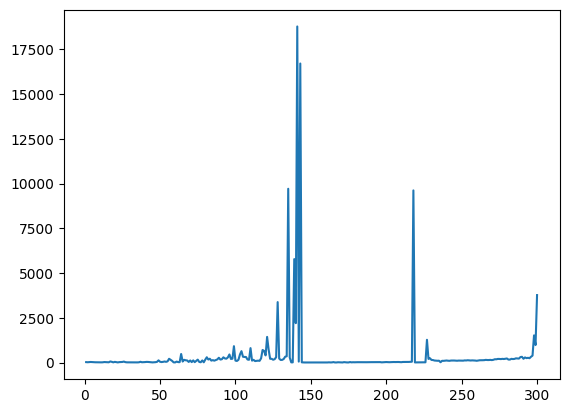

In [103]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)

n_games = 300

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    (observation, _) = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, _, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)
x = [i + 1 for i in range(len(score_history))]
plt.plot(x, score_history)

In [8]:
%pip install -e ../.

Obtaining file:///P:/repos/cellitaire-rl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for cellitaire (pyproject.toml): started
  Building editable for cellitaire (pyproject.toml): finished with status 'done'
  Created wheel for cellitaire: filename=cellitaire-0.0.1-0.editable-py3-none-any.whl size=1308 sha256=517006ee0bca82cab2919450b3a5e2d500fd61d7da4ba7b6668fd760ce720207
  Stored in directory: C:\Users\Noe\AppData\Local\Temp\pip-ephem-wheel-cache-vvd6x7s5\wheels\76\88\96\576254946bf13aa1d012dfa539e7e5e1fddd6ac7e334da0df2
